# **Description**


*   Filtering High-Performing Businesses: The code filters businesses in Phoenix
with high ratings (≥4 stars) and a significant number of customer reviews (≥100), focusing on top-performing entities.
*Graph Construction: A graph is built where nodes represent businesses, and edges indicate shared customer relationships, with edge weights calculated based on mutual customer ratios.


*   
Incorporating Ricci Curvature: Ricci curvature measures, including Ollivier-Ricci and Forman-Ricci, are applied to the graph to enhance its structural understanding and capture geometric properties.
*  
Clustering Businesses: The curvature-enhanced graph is used to cluster businesses, identifying groups with similar customer relationships and structural properties.



*  
Review Analysis: Reviews from clustered businesses are analyzed using normalized word counts and LDA topic modeling to extract themes and gain insights into customer behavior and business synergies.


In [1]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

df_business = pd.read_csv('/content/drive/My Drive/Yelp data/yelp_business.csv')
df_review = pd.read_csv('/content/drive/My Drive/Yelp data/yelp_review.csv')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re


# Step 1: Define Standard Categories
standard_categories = [
    "Restaurants",
    "Nightlife",
    "Shopping",
    "Health & Medical",
    "Home Services",
    "Automotive",
    "Beauty & Spas",
    "Arts & Entertainment",
    "Sports & Recreation",
    "Food & Beverages"
]

# Step 2: Preprocess Categories
def preprocess_categories(categories):
    if pd.isna(categories):
        return ""
    # Split categories by delimiters and normalize text
    tokens = re.split(r'[;|,]', categories.lower())
    tokens = [token.strip() for token in tokens if token.strip()]
    return " ".join(tokens)

# Preprocess the business categories
df_business['processed_categories'] = df_business['categories'].apply(preprocess_categories)

# Step 3: Calculate Similarity
# Vectorize standard categories and processed business categories
vectorizer = TfidfVectorizer(stop_words="english")
standard_category_vectors = vectorizer.fit_transform(standard_categories)
business_category_vectors = vectorizer.transform(df_business['processed_categories'])

# Compute cosine similarity between business categories and standard categories
similarity_matrix = cosine_similarity(business_category_vectors, standard_category_vectors)

# Assign the most similar standard category
df_business['refined_category'] = similarity_matrix.argmax(axis=1).astype(int)
df_business['refined_category'] = df_business['refined_category'].apply(lambda x: standard_categories[x])

# Step 4: Save or Preview Results
print(df_business[['categories', 'processed_categories', 'refined_category']].head(10))


                                          categories  \
0  Dentists;General Dentistry;Health & Medical;Or...   
1  Hair Stylists;Hair Salons;Men's Hair Salons;Bl...   
2  Departments of Motor Vehicles;Public Services ...   
3                            Sporting Goods;Shopping   
4  American (New);Nightlife;Bars;Sandwiches;Ameri...   
5                                Italian;Restaurants   
6  Real Estate Services;Real Estate;Home Services...   
7                            Shopping;Sporting Goods   
8        Coffee & Tea;Ice Cream & Frozen Yogurt;Food   
9                          Automotive;Auto Detailing   

                                processed_categories  refined_category  
0  dentists general dentistry health & medical or...  Health & Medical  
1  hair stylists hair salons men's hair salons bl...     Beauty & Spas  
2  departments of motor vehicles public services ...     Home Services  
3                            sporting goods shopping          Shopping  
4  american (new) 

In [3]:
# Count unique categories
unique_categories = df_business['refined_category'].nunique()
print(f"Number of unique categories: {unique_categories}")

# Display the count of businesses in each category
category_counts = df_business['refined_category'].value_counts()
print("Number of businesses in each category:")
print(category_counts)


Number of unique categories: 10
Number of businesses in each category:
refined_category
Restaurants             58619
Home Services           35950
Shopping                17635
Beauty & Spas           14822
Food & Beverages        14569
Health & Medical        13626
Automotive               9764
Arts & Entertainment     5517
Nightlife                3571
Sports & Recreation       494
Name: count, dtype: int64


In [4]:
# Filter Phoenix businesses
phoenix_businesses = df_business[df_business['city'] == 'Phoenix'][['business_id', 'name', 'city', 'categories','refined_category']]

# Filter reviews for businesses with >= 4 stars
phoenix_reviews = df_review[df_review['stars'] >= 4].merge(
    phoenix_businesses, on='business_id'
)


In [5]:
review_counts = phoenix_reviews.groupby('business_id')['user_id'].count().reset_index()
review_counts.columns = ['business_id', 'review_count']
high_review_businesses = review_counts[review_counts['review_count'] >= 100]
filtered_reviews = phoenix_reviews[phoenix_reviews['business_id'].isin(high_review_businesses['business_id'])]


Identify mutual customers: Group reviews by user_id to find businesses reviewed by the same customer.

In [6]:
from collections import defaultdict # Import the defaultdict class from the collections module

mutual_customers = defaultdict(lambda: defaultdict(int))
for user, group in filtered_reviews.groupby('user_id'):
    businesses = group['business_id'].tolist()
    for i, business_a in enumerate(businesses):
        for business_b in businesses[i + 1:]:
            mutual_customers[business_a][business_b] += 1
            mutual_customers[business_b][business_a] += 1

Count unique customers per business: This helps normalize relationships later.

In [7]:
business_customers_count = filtered_reviews.groupby('business_id')['user_id'].nunique().to_dict()


calculates edge weights for a graph based on the number of mutual customers between pairs of businesses.

In [8]:
edge_weights = {}
for business_a, neighbors in mutual_customers.items():
    customers_a = business_customers_count.get(business_a, 0)
    for business_b, mutual_count in neighbors.items():
        customers_b = business_customers_count.get(business_b, 0)
        if customers_a == 0 or customers_b == 0:
            continue
        weight = (mutual_count / customers_a + mutual_count / customers_b) / 2
        edge_weights[(business_a, business_b)] = weight


Construct the Graph

In [9]:
import networkx as nx
G = nx.Graph()
for (business_a, business_b), weight in edge_weights.items():
    G.add_edge(business_a, business_b, weight=weight)


Add Node Attributes (Optional): can add meaningful attributes (e.g., business names or categories) for clarity in visualization:

In [10]:
business_id_to_name = dict(zip(phoenix_businesses['business_id'], phoenix_businesses['name']))
for node in G.nodes:
    G.nodes[node]['label'] = business_id_to_name.get(node, 'Unknown')


Plot the Graph: Use matplotlib to draw the graph:

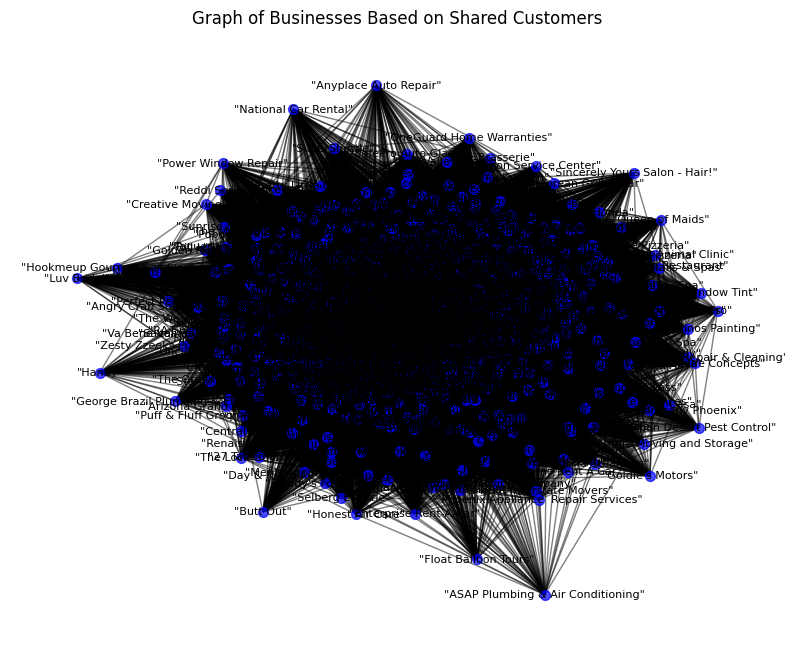

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, weight='weight')  # Use edge weights for layout

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.5)


labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title("Graph of Businesses Based on Shared Customers")
plt.axis('off')
plt.show()


In [12]:
num_nodes = G.number_of_nodes()
print(f"Number of nodes (businesses): {num_nodes}")
num_edges = G.number_of_edges()
print(f"Number of edges (connections): {num_edges}")


Number of nodes (businesses): 822
Number of edges (connections): 218182


In [13]:
import pandas as pd

# Extract edge list with weights
edge_list = []
for edge in G.edges(data=True):
    node_a = edge[0]
    node_b = edge[1]
    weight = edge[2].get('weight', 1)  # Default weight is 1 if not specified
    edge_list.append((node_a, node_b, weight))

# Create a DataFrame for the edge list
edge_list_df = pd.DataFrame(edge_list, columns=['Source', 'Target', 'Weight'])
edge_list_df.to_csv('edge_list.csv', index=False)

# Display the edge list
print(edge_list_df)


                        Source                  Target    Weight
0       lsHmnOZNlsKnEDsNmT-5_Q  E5AMBRf_2ZdawMMp1nG2eQ  0.006120
1       lsHmnOZNlsKnEDsNmT-5_Q  46hnat0aLao-qYWZkN9aBg  0.007438
2       lsHmnOZNlsKnEDsNmT-5_Q  rswuhMY5vCbvZvF2wBIhqg  0.005793
3       lsHmnOZNlsKnEDsNmT-5_Q  zOL260xaXDYZZPBItzALxQ  0.016303
4       lsHmnOZNlsKnEDsNmT-5_Q  OGRB__fguKfGpPdH7FvBDA  0.008152
...                        ...                     ...       ...
218177  oVFRqhwQQ3zD3geTtRYZTA  nNavjod8pAkEW7ZHeCyAbA  0.008368
218178  oVFRqhwQQ3zD3geTtRYZTA  mQ9sBO4jSO_2W-0_mb_SNA  0.008591
218179  sZq-qUvoLgYxlDmIcxYWDg  lCI3S_Tb16uW3TOk-wMizA  0.009098
218180  lCI3S_Tb16uW3TOk-wMizA  mQ9sBO4jSO_2W-0_mb_SNA  0.008523
218181  QEE5vBdRf2tuchmZQ3H-Kg  nNavjod8pAkEW7ZHeCyAbA  0.007905

[218182 rows x 3 columns]


In [14]:


# Extract node list with attributes
node_list = []
for node, attributes in G.nodes(data=True):
    # Collect node and its attributes
    node_name = attributes.get('label', 'Unknown')  # Default label is 'Unknown' if not specified
    node_list.append((node, node_name))

# Create a DataFrame for the node list
node_list_df = pd.DataFrame(node_list, columns=['Node', 'Label'])
node_list_df.to_csv('node_list.csv', index=False)

# Display the node list
print(node_list_df)


                       Node                                  Label
0    lsHmnOZNlsKnEDsNmT-5_Q          "American Home Water and Air"
1    E5AMBRf_2ZdawMMp1nG2eQ                "Moon Valley Nurseries"
2    46hnat0aLao-qYWZkN9aBg                      "Los Dos Molinos"
3    rswuhMY5vCbvZvF2wBIhqg                    "Sun Asian Kitchen"
4    zOL260xaXDYZZPBItzALxQ    "MacAlpine's Diner & Soda Fountain"
..                      ...                                    ...
817  mQ9sBO4jSO_2W-0_mb_SNA            "PreFlight Airport Parking"
818  HHu9VyoA7RB1AR2NIFiT7g                  "Float Balloon Tours"
819  QEE5vBdRf2tuchmZQ3H-Kg                     "Arizona Steamers"
820  nkYnC7aj-vgFfjEOjv7_gA                             "Butt Out"
821  nNavjod8pAkEW7ZHeCyAbA  "Arizona Brothers Moving and Storage"

[822 rows x 2 columns]


visualizing smaller subgraph

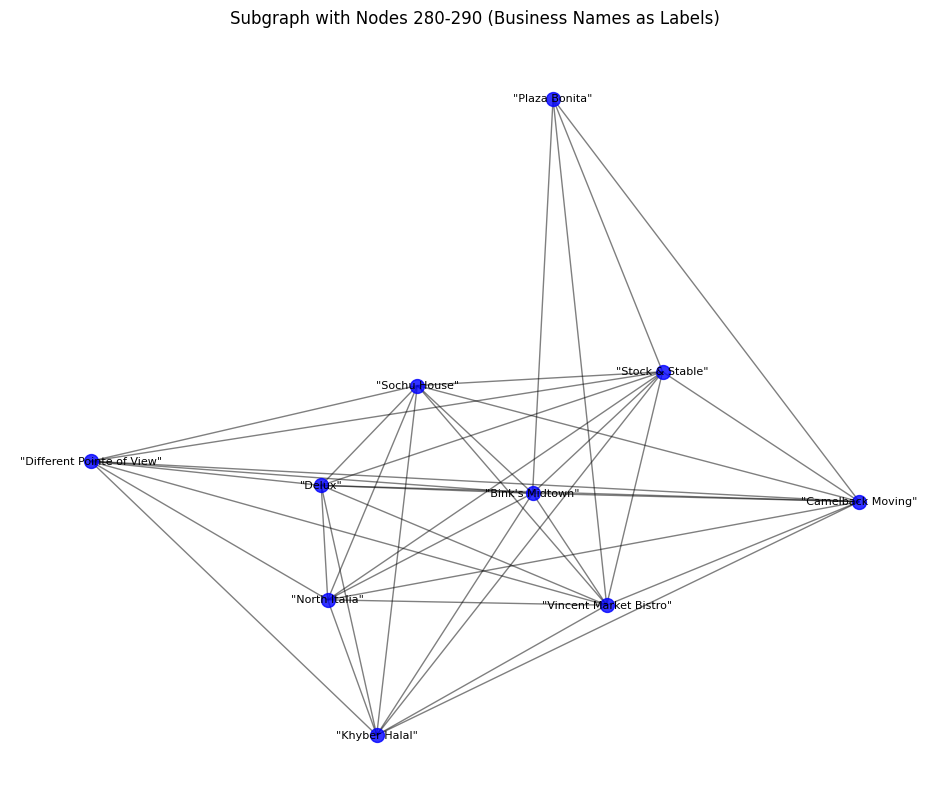

Number of nodes in subgraph: 10
Number of edges in subgraph: 40


In [ ]:
business_id_to_name = dict(zip(phoenix_businesses['business_id'], phoenix_businesses['name']))

# Get a list of all nodes in the graph
all_nodes = list(G.nodes)

# Select a subset of nodes (e.g., nodes 280 to 290)
subset_nodes = all_nodes[280:290]

# Create a subgraph with all attributes preserved
subgraph = G.subgraph(subset_nodes).copy()

# Assign business names as node labels
for node in subgraph.nodes:
    subgraph.nodes[node]['label'] = business_id_to_name.get(node, 'Unknown')

# Prepare positions for plotting
pos = nx.spring_layout(subgraph, seed=42, weight='weight')  # Layout with edge weights

# Plot the subgraph
plt.figure(figsize=(12, 10))

# Draw nodes and edges
nx.draw_networkx_nodes(subgraph, pos, node_size=100, node_color='blue', alpha=0.8)
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)

# Use the 'label' attribute for node labels
node_labels = nx.get_node_attributes(subgraph, 'label')
nx.draw_networkx_labels(subgraph, pos, labels=node_labels, font_size=8)

# Title and display
plt.title("Subgraph with Nodes 280-290 (Business Names as Labels)")
plt.axis('off')
plt.show()

# Print subgraph information
print(f"Number of nodes in subgraph: {subgraph.number_of_nodes()}")
print(f"Number of edges in subgraph: {subgraph.number_of_edges()}")


graph filtering and component extraction.

In [15]:
# Filter edges with low weights and isolate the largest connected component
def filter_edges_by_weight(graph, threshold):
    filtered_edges = [(u, v, d['weight']) for u, v, d in graph.edges(data=True) if d['weight'] > threshold]
    new_graph = nx.Graph()
    new_graph.add_weighted_edges_from(filtered_edges)
    return new_graph

def get_largest_connected_component(graph):
    largest_cc = max(nx.connected_components(graph), key=len)
    return graph.subgraph(largest_cc).copy()

WEIGHT_THRESHOLD = 0.01 #0.01 implies that the average proportion of mutual customers (considering both businesses) must be at least 1% for the connection to be regarded as meaningfu
G_filtered = filter_edges_by_weight(G, WEIGHT_THRESHOLD)
G_largest_cc = get_largest_connected_component(G_filtered)


In [16]:
num_nodes = G_largest_cc.number_of_nodes()
print(f"Number of nodes (businesses): {num_nodes}")
num_edges = G_largest_cc.number_of_edges()
print(f"Number of edges (connections): {num_edges}")

Number of nodes (businesses): 822
Number of edges (connections): 127205


In [ ]:
import pandas as pd

# Extract edge list with weights
edge_list = []
for edge in G_largest_cc.edges(data=True):
    node_a = edge[0]
    node_b = edge[1]
    weight = edge[2].get('weight', 1)  # Default weight is 1 if not specified
    edge_list.append((node_a, node_b, weight))

# Create a DataFrame for the edge list
edge_list_df = pd.DataFrame(edge_list, columns=['Source', 'Target', 'Weight'])
edge_list_df.to_csv('edge_list_filter.csv', index=False)

# Display the edge list
print(edge_list_df)


                        Source                  Target    Weight
0       lsHmnOZNlsKnEDsNmT-5_Q  zOL260xaXDYZZPBItzALxQ  0.016303
1       lsHmnOZNlsKnEDsNmT-5_Q  YgVC9NdMji-VV05w7-E1DQ  0.011474
2       lsHmnOZNlsKnEDsNmT-5_Q  iE71iwcSljg3xm2GB2Y9aA  0.010052
3       lsHmnOZNlsKnEDsNmT-5_Q  J3iWlSa27BmyvX2XwJt3Yw  0.010432
4       lsHmnOZNlsKnEDsNmT-5_Q  FirWX-Ep5203TsdiGgShKg  0.011830
...                        ...                     ...       ...
127200  M-ajUawvXeHSqpeM_2UDOg  r3Xx9Qk3xAMzYGIGFBcKpQ  0.010301
127201  iNDTltptdI3PYOxxXtnyLQ  wQWhzyZNzFQKAOiSVEXCwA  0.012691
127202  W3HI9tfQ8DAAJdkVWz5dQw  SkORg8POszk8OlJjFncegQ  0.012719
127203  SkORg8POszk8OlJjFncegQ  RwnePLERBTS_xtyV7Rx1AQ  0.010653
127204  RwnePLERBTS_xtyV7Rx1AQ  zjBJPx2Hm-cx1xfeIjcKHQ  0.012121

[127205 rows x 3 columns]


In [17]:


# Extract node list with attributes
node_list = []
for node, attributes in G_largest_cc.nodes(data=True):
    # Collect node and its attributes
    node_name = attributes.get('label', 'Unknown')  # Default label is 'Unknown' if not specified
    node_list.append((node, node_name))

# Create a DataFrame for the node list
node_list_df = pd.DataFrame(node_list, columns=['Node', 'Label'])
node_list_df.to_csv('node_list_filtered.csv', index=False)

# Display the node list
print(node_list_df)


                       Node    Label
0    lsHmnOZNlsKnEDsNmT-5_Q  Unknown
1    zOL260xaXDYZZPBItzALxQ  Unknown
2    YgVC9NdMji-VV05w7-E1DQ  Unknown
3    iE71iwcSljg3xm2GB2Y9aA  Unknown
4    J3iWlSa27BmyvX2XwJt3Yw  Unknown
..                      ...      ...
817  QEE5vBdRf2tuchmZQ3H-Kg  Unknown
818  4JdoQ95uXy__zoHmPhtdiA  Unknown
819  v3AXp8DPMgwpy4DX4DDZNw  Unknown
820  -cx5skKcusn__Q4bMx7X5g  Unknown
821  zjBJPx2Hm-cx1xfeIjcKHQ  Unknown

[822 rows x 2 columns]


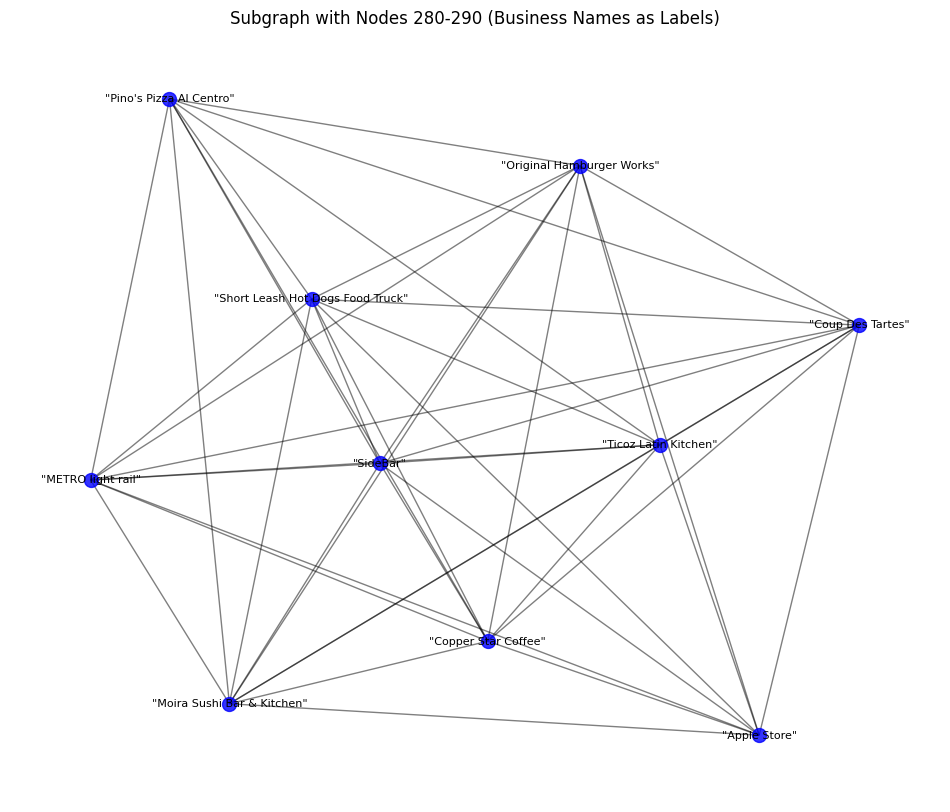

Number of nodes in subgraph: 10
Number of edges in subgraph: 44


In [ ]:
business_id_to_name = dict(zip(phoenix_businesses['business_id'], phoenix_businesses['name']))

# Get a list of all nodes in the graph
all_nodes = list(G_largest_cc.nodes)

# Select a subset of nodes (e.g., nodes 280 to 290)
subset_nodes = all_nodes[280:290]

# Create a subgraph with all attributes preserved
subgraph_cc= G_largest_cc.subgraph(subset_nodes).copy()

# Assign business names as node labels
for node in subgraph_cc.nodes:
    subgraph_cc.nodes[node]['label'] = business_id_to_name.get(node, 'Unknown')

# Prepare positions for plotting
pos = nx.spring_layout(subgraph_cc, seed=42, weight='weight')  # Layout with edge weights

# Plot the subgraph
plt.figure(figsize=(12, 10))

# Draw nodes and edges
nx.draw_networkx_nodes(subgraph_cc, pos, node_size=100, node_color='blue', alpha=0.8)
nx.draw_networkx_edges(subgraph_cc, pos, alpha=0.5)

# Use the 'label' attribute for node labels
node_labels = nx.get_node_attributes(subgraph_cc, 'label')
nx.draw_networkx_labels(subgraph_cc, pos, labels=node_labels, font_size=8)


plt.title("Subgraph with Nodes 280-290 (Business Names as Labels)")
plt.axis('off')
plt.show()

# Print subgraph information
print(f"Number of nodes in subgraph: {subgraph_cc.number_of_nodes()}")
print(f"Number of edges in subgraph: {subgraph_cc.number_of_edges()}")


Subgraph on same nodes before and after filtering

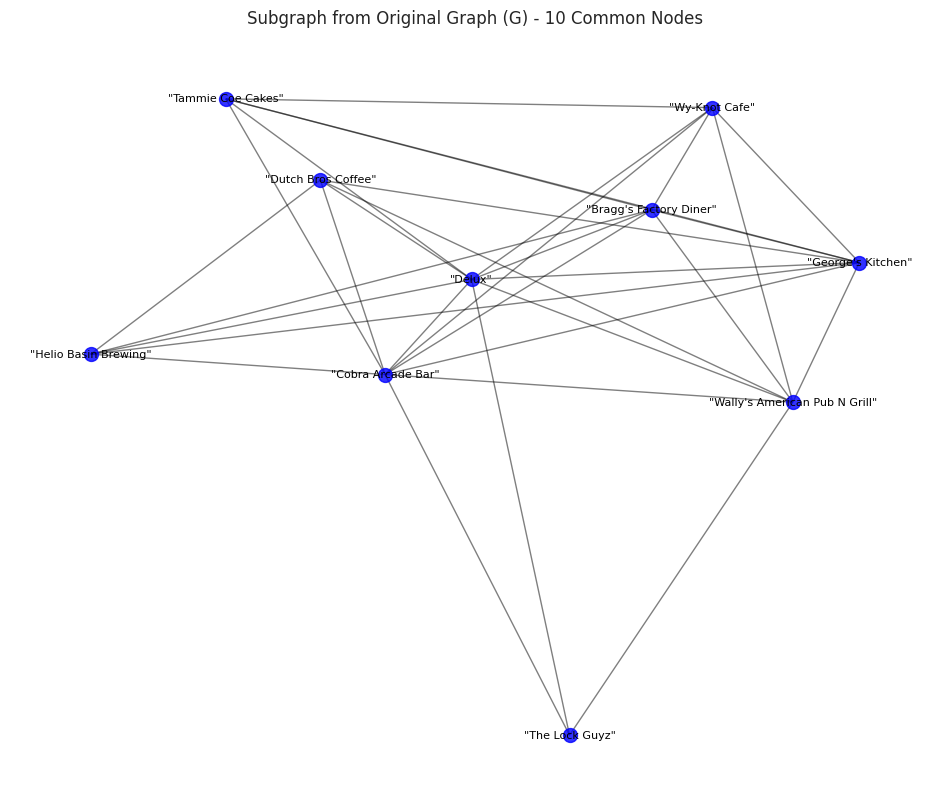

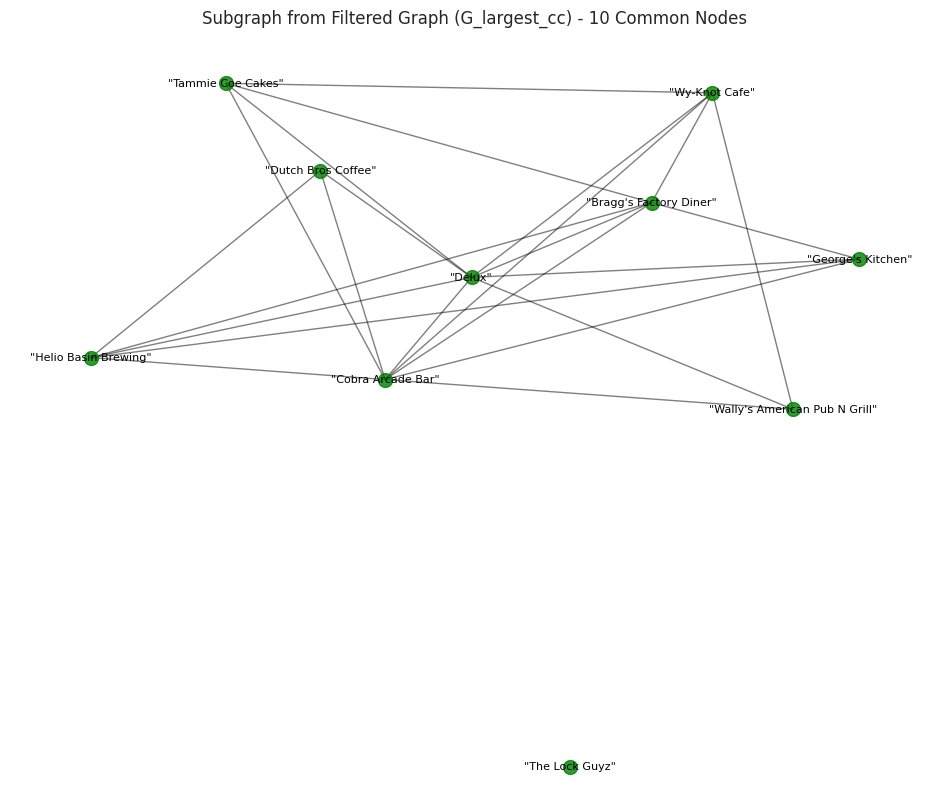

Original Graph Subgraph (Before Filtering):
Number of nodes: 10
Number of edges: 32

Filtered Graph Subgraph (After Filtering):
Number of nodes: 10
Number of edges: 23


In [ ]:

business_id_to_name = dict(zip(phoenix_businesses['business_id'], phoenix_businesses['name']))

# Step 1: Find common nodes
common_nodes = list(set(G.nodes).intersection(set(G_largest_cc.nodes)))

# Select the first 10 nodes from the common nodes
selected_nodes = common_nodes[:10]

# Step 2: Create subgraphs using the selected 10 nodes
subgraph_G = G.subgraph(selected_nodes).copy()
subgraph_G_largest_cc = G_largest_cc.subgraph(selected_nodes).copy()

# Step 3: Assign business names as node labels
for node in selected_nodes:
    label = business_id_to_name.get(node, "Unknown")
    subgraph_G.nodes[node]['label'] = label
    subgraph_G_largest_cc.nodes[node]['label'] = label

# Step 4: Prepare positions for consistent layout
pos = nx.spring_layout(subgraph_G, seed=42, weight='weight')

# Step 5: Plot subgraph from G (Before Filtering)
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(subgraph_G, pos, node_size=100, node_color='blue', alpha=0.8)
nx.draw_networkx_edges(subgraph_G, pos, alpha=0.5)
node_labels = nx.get_node_attributes(subgraph_G, 'label')
nx.draw_networkx_labels(subgraph_G, pos, labels=node_labels, font_size=8)
plt.title("Subgraph from Original Graph (G) - 10 Common Nodes")
plt.axis('off')
plt.show()

# Step 6: Plot subgraph from G_largest_cc (After Filtering)
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(subgraph_G_largest_cc, pos, node_size=100, node_color='green', alpha=0.8)
nx.draw_networkx_edges(subgraph_G_largest_cc, pos, alpha=0.5)
node_labels = nx.get_node_attributes(subgraph_G_largest_cc, 'label')
nx.draw_networkx_labels(subgraph_G_largest_cc, pos, labels=node_labels, font_size=8)
plt.title("Subgraph from Filtered Graph (G_largest_cc) - 10 Common Nodes")
plt.axis('off')
plt.show()

# Step 7: Print information about both subgraphs
print("Original Graph Subgraph (Before Filtering):")
print(f"Number of nodes: {subgraph_G.number_of_nodes()}")
print(f"Number of edges: {subgraph_G.number_of_edges()}")

print("\nFiltered Graph Subgraph (After Filtering):")
print(f"Number of nodes: {subgraph_G_largest_cc.number_of_nodes()}")
print(f"Number of edges: {subgraph_G_largest_cc.number_of_edges()}")


In [ ]:
graph_business_ids = set(G_largest_cc.nodes)

# Filter businesses in the graph to include their categories
graph_businesses = phoenix_businesses[phoenix_businesses['business_id'].isin(graph_business_ids)]

# Split categories if they are comma-separated
graph_businesses['refined_category'] = graph_businesses['refined_category'].str.split(',')

# Explode categories into separate rows for counting
exploded_categories = graph_businesses.explode('refined_category')

# Strip whitespace and normalize category names
exploded_categories['refined_category'] = exploded_categories['refined_category'].str.strip()

# Count unique categories
unique_categories = exploded_categories['refined_category'].nunique()
print(f"Number of unique business categories: {unique_categories}")

# Count the number of businesses in each category
category_counts = exploded_categories['refined_category'].value_counts()
print("Number of businesses in each category:")
print(category_counts)


Number of unique business categories: 9
Number of businesses in each category:
refined_category
Restaurants             593
Food & Beverages         68
Home Services            66
Arts & Entertainment     27
Beauty & Spas            24
Automotive               22
Shopping                 11
Nightlife                 9
Health & Medical          2
Name: count, dtype: int64


<ipython-input-27-e6142bf8498a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_businesses['refined_category'] = graph_businesses['refined_category'].str.split(',')


ricci curvature

In [ ]:
!pip install GraphRicciCurvature

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 43.9 MB/s eta 0:00:00


Ollivier Ricci Curvature

In [ ]:
from GraphRicciCurvature.OllivierRicci import OllivierRicci

# Compute Ricci curvature for the largest connected component
orc = OllivierRicci(G_largest_cc, alpha=0.5, verbose="INFO")
orc.compute_ricci_curvature()

# Attach Ricci curvature to the graph
for u, v, data in G_largest_cc.edges(data=True):
    data['ricciCurvature'] = orc.G[u][v]["ricciCurvature"]

print("Ricci curvature computed and added as edge attributes.")


INFO:GraphRicciCurvature:2669.907505 secs for Ricci curvature computation.


Ricci curvature computed and added as edge attributes.


In [ ]:
import networkx as nx

# Retrieve Ricci curvature values
ollivier_ricci_values = nx.get_edge_attributes(G_largest_cc, "ricciCurvature")

# Check if values are present
if not ollivier_ricci_values:
    raise ValueError("No Ricci curvature values found! Ensure Ricci curvature is computed.")

# Print example curvature values
print(f"Example curvature values: {list(ollivier_ricci_values.items())[:5]}")


Example curvature values: [(('lsHmnOZNlsKnEDsNmT-5_Q', 'zOL260xaXDYZZPBItzALxQ'), 0.1576470618880268), (('lsHmnOZNlsKnEDsNmT-5_Q', 'YgVC9NdMji-VV05w7-E1DQ'), -0.0020304392974095364), (('lsHmnOZNlsKnEDsNmT-5_Q', 'iE71iwcSljg3xm2GB2Y9aA'), -0.05939559927217908), (('lsHmnOZNlsKnEDsNmT-5_Q', 'J3iWlSa27BmyvX2XwJt3Yw'), -0.03044905357847827), (('lsHmnOZNlsKnEDsNmT-5_Q', 'FirWX-Ep5203TsdiGgShKg'), 0.012093163138987895)]


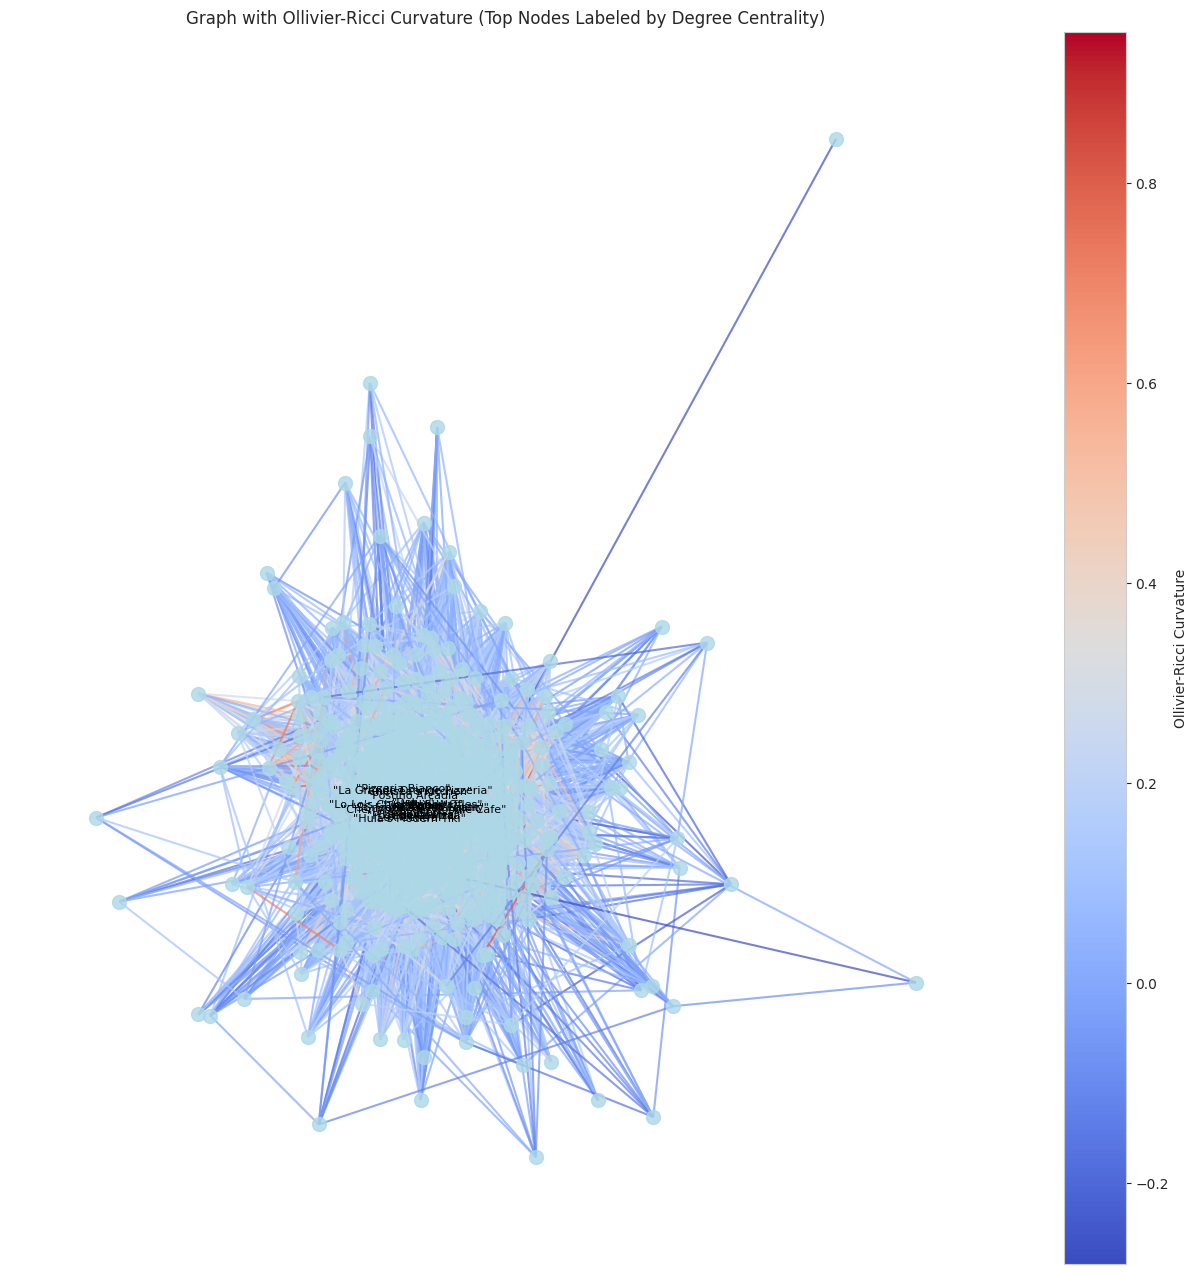

Curvature range: -0.2810 to 0.9507
Interpretation:
 - Bright red: High positive curvature (stronger connections).
 - Bright blue: High negative curvature (weaker connections).


In [ ]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx

# Ensure `business_id_to_name` contains the mapping of business IDs to business names
business_id_to_name = dict(zip(phoenix_businesses['business_id'], phoenix_businesses['name']))

# Assign names to node labels in the subgraph
for node in G_largest_cc.nodes:
    G_largest_cc.nodes[node]['label'] = business_id_to_name.get(node, 'Unknown')

# Extract Ricci curvature values
curvature_values = list(nx.get_edge_attributes(G_largest_cc, "ricciCurvature").values())

# Normalize curvature values for color mapping
norm = mcolors.Normalize(vmin=min(curvature_values), vmax=max(curvature_values), clip=True)
cmap = plt.cm.coolwarm  # Choose a colormap (e.g., coolwarm, viridis)

# Prepare positions for nodes
pos = nx.spring_layout(G_largest_cc, seed=42)

plt.figure(figsize=(16, 16))

# Draw nodes
nx.draw_networkx_nodes(G_largest_cc, pos, node_size=100, node_color="lightblue", alpha=0.8)

# Draw edges with curvature-based color mapping
nx.draw_networkx_edges(
    G_largest_cc,
    pos,
    edge_color=curvature_values,  # Use curvature values for edge color
    edge_cmap=cmap,
    edge_vmin=min(curvature_values),
    edge_vmax=max(curvature_values),
    width=1.5,
    alpha=0.7,
)

# Display labels for top central nodes only (to avoid overcrowding)
node_labels = nx.get_node_attributes(G_largest_cc, 'label')
central_nodes = sorted(
    G_largest_cc.degree, key=lambda x: x[1], reverse=True
)[:20]  # Top 20 nodes by degree centrality
central_node_labels = {node: node_labels[node] for node, _ in central_nodes}
nx.draw_networkx_labels(G_largest_cc, pos, labels=central_node_labels, font_size=8, font_color="black")

# Add colorbar tied to the edges
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Assign empty array to ScalarMappable
plt.colorbar(sm, ax=plt.gca(), label="Ollivier-Ricci Curvature")

# Add title and display
plt.title("Graph with Ollivier-Ricci Curvature (Top Nodes Labeled by Degree Centrality)")
plt.axis("off")
plt.show()

# Print curvature range and interpretation
print(f"Curvature range: {min(curvature_values):.4f} to {max(curvature_values):.4f}")
print("Interpretation:")
print(" - Bright red: High positive curvature (stronger connections).")
print(" - Bright blue: High negative curvature (weaker connections).")


INFO:GraphRicciCurvature:0.709392 secs for Ricci curvature computation.


Ricci curvature computed and added as edge attributes for the subgraph.


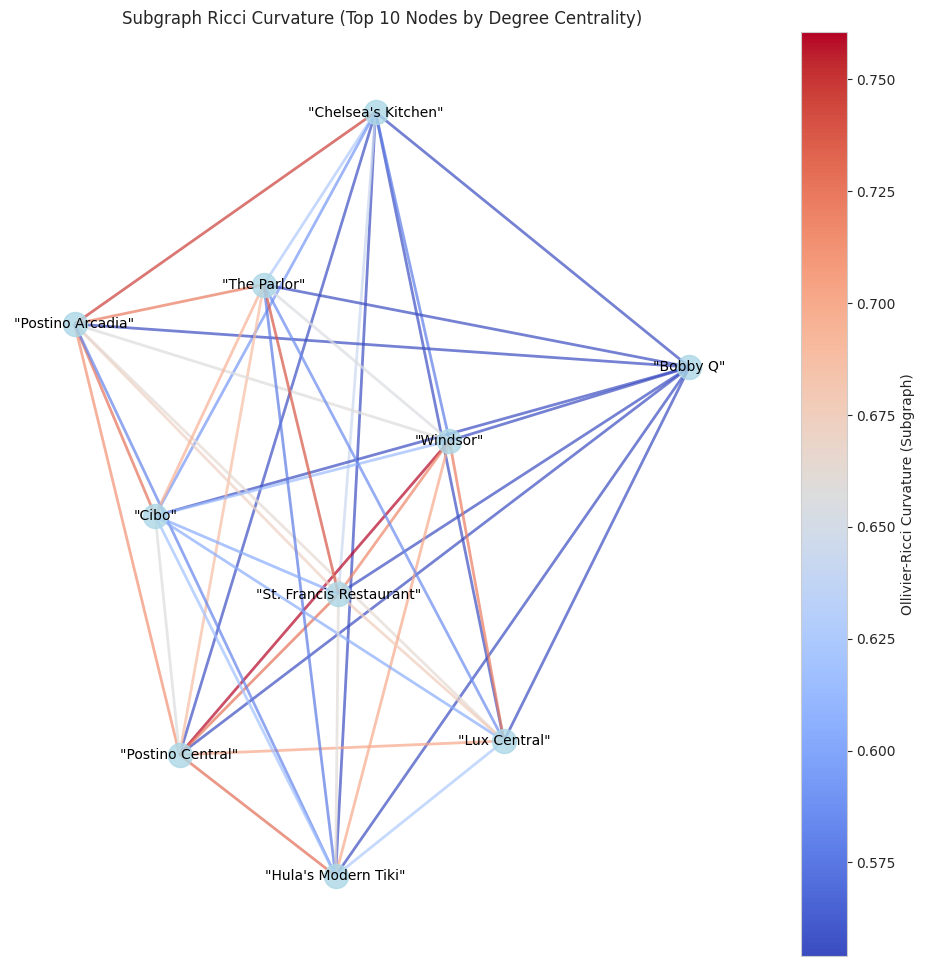

Subgraph Curvature Range: 0.5541 to 0.7605
Interpretation:
 - Bright red: High positive curvature (stronger connections).
 - Bright blue: High negative curvature (weaker connections).


In [ ]:
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from GraphRicciCurvature.OllivierRicci import OllivierRicci

# Ensure `business_id_to_name` contains the mapping of business IDs to business names
business_id_to_name = dict(zip(phoenix_businesses['business_id'], phoenix_businesses['name']))

# Step 1: Extract a subgraph with a specific set of nodes (e.g., top 10 nodes by degree centrality)
top_nodes = sorted(G_largest_cc.degree, key=lambda x: x[1], reverse=True)[:10]
subgraph_nodes = [node for node, _ in top_nodes]
subgraph = G_largest_cc.subgraph(subgraph_nodes).copy()

# Step 2: Assign business names to node labels in the subgraph
for node in subgraph.nodes:
    subgraph.nodes[node]['label'] = business_id_to_name.get(node, 'Unknown')

# Step 3: Compute Ricci curvature for the subgraph
orc_subgraph = OllivierRicci(subgraph, alpha=0.5, verbose="INFO")
orc_subgraph.compute_ricci_curvature()

# Attach Ricci curvature as edge attributes
for u, v, data in subgraph.edges(data=True):
    data['ricciCurvature'] = orc_subgraph.G[u][v]["ricciCurvature"]

print("Ricci curvature computed and added as edge attributes for the subgraph.")

# Step 4: Extract Ricci curvature values
curvature_values_subgraph = list(nx.get_edge_attributes(subgraph, "ricciCurvature").values())

# Normalize curvature values for color mapping
norm_subgraph = mcolors.Normalize(vmin=min(curvature_values_subgraph), vmax=max(curvature_values_subgraph), clip=True)
cmap_subgraph = plt.cm.coolwarm  # Choose a colormap

# Step 5: Prepare positions for the subgraph nodes
pos_subgraph = nx.spring_layout(subgraph, seed=42)

plt.figure(figsize=(12, 12))

# Draw nodes with names as labels
nx.draw_networkx_nodes(subgraph, pos_subgraph, node_size=300, node_color="lightblue", alpha=0.8)

# Draw edges with curvature-based color mapping
nx.draw_networkx_edges(
    subgraph,
    pos_subgraph,
    edge_color=curvature_values_subgraph,  # Use curvature values for edge color
    edge_cmap=cmap_subgraph,
    edge_vmin=min(curvature_values_subgraph),
    edge_vmax=max(curvature_values_subgraph),
    width=2.0,
    alpha=0.7,
)

# Use the 'label' attribute for node labels
node_labels_subgraph = nx.get_node_attributes(subgraph, 'label')
nx.draw_networkx_labels(subgraph, pos_subgraph, labels=node_labels_subgraph, font_size=10, font_color="black")

# Add a colorbar tied to the edges
sm_subgraph = plt.cm.ScalarMappable(norm=norm_subgraph, cmap=cmap_subgraph)
sm_subgraph.set_array([])  # Assign empty array to ScalarMappable
plt.colorbar(sm_subgraph, ax=plt.gca(), label="Ollivier-Ricci Curvature (Subgraph)")

# Add title and display
plt.title("Subgraph Ricci Curvature (Top 10 Nodes by Degree Centrality)")
plt.axis("off")
plt.show()

# Print curvature range and interpretation
print(f"Subgraph Curvature Range: {min(curvature_values_subgraph):.4f} to {max(curvature_values_subgraph):.4f}")
print("Interpretation:")
print(" - Bright red: High positive curvature (stronger connections).")
print(" - Bright blue: High negative curvature (weaker connections).")




to save the graph as pickle file

In [ ]:
import pickle
from google.colab import files

# Save the graph to a file
pickle_file = "graph_Yelp_filtered.pkl"
with open(pickle_file, "wb") as f:
    pickle.dump(G_largest_cc, f)

print(f"Graph with Ollivier-Ricci curvature saved to '{pickle_file}'.")

# Download the file in Colab
files.download(pickle_file)


Graph with Ollivier-Ricci curvature saved to 'graph_Yelp_filtered.pkl'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

saving oliver ricci values in json file

In [ ]:
import json

# Convert dictionary keys (tuples) to strings for JSON serialization
ollivier_ricci_values_serializable = {str(key): value for key, value in ollivier_ricci_values.items()}

# Save to JSON file
json_file = "ollivier_ricci_values.json"
with open(json_file, "w") as f:
    json.dump(ollivier_ricci_values_serializable, f)

print(f"Ollivier-Ricci curvature values saved to '{json_file}'.")


Ollivier-Ricci curvature values saved to 'ollivier_ricci_values.json'.


forman ricci

In [ ]:
from GraphRicciCurvature.FormanRicci import FormanRicci

def relabel_graph_to_integers(graph):
    mapping = {node: idx for idx, node in enumerate(graph.nodes())}
    graph_int = nx.relabel_nodes(graph, mapping)
    return graph_int, mapping

G_largest_cc_int, node_mapping = relabel_graph_to_integers(G_largest_cc)



INFO:GraphRicciCurvature:Node weight not detected in graph, use "weight" as default node weight.


In [ ]:
from GraphRicciCurvature.FormanRicci import FormanRicci

# Initialize and compute Forman-Ricci curvature
fr = FormanRicci(G_largest_cc_int)
fr.compute_ricci_curvature()

# Assign curvature values to edges
for u, v, data in G_largest_cc_int.edges(data=True):
    data['formanCurvature'] = fr.G[u][v].get("formanCurvature", None)

# Verify curvature assignment
forman_ricci_values = nx.get_edge_attributes(G_largest_cc_int, "formanCurvature")
print(f"Example edges with Forman-Ricci curvature: {list(forman_ricci_values.items())[:5]}")


Example edges with Forman-Ricci curvature: [((0, 1), -381.71446297323376), ((0, 2), -407.95053305359824), ((0, 3), -234.68106179148796), ((0, 4), -256.5295327372365), ((0, 5), -402.51351937443155)]


In [ ]:
print(nx.get_edge_attributes(G_largest_cc_int, "formanCurvature"))


{}


In [ ]:
print(list(G_largest_cc_int.edges(data=True))[:5])  # Print first 5 edges and their attributes


[(0, 1, {'weight': 0.016303470540758678, 'ricciCurvature': 0.1576470618880268}), (0, 2, {'weight': 0.011474496697700325, 'ricciCurvature': -0.0020304392974095364}), (0, 3, {'weight': 0.010051633179930408, 'ricciCurvature': -0.05939559927217908}), (0, 4, {'weight': 0.010432084029601336, 'ricciCurvature': -0.03044905357847827}), (0, 5, {'weight': 0.011830166067454203, 'ricciCurvature': 0.012093163138987895})]


In [ ]:
print("Relabeled Graph (G_largest_cc_int):")
print(f"Number of nodes: {G_largest_cc_int.number_of_nodes()}")
print(f"Number of edges: {G_largest_cc_int.number_of_edges()}")
print(list(G_largest_cc_int.edges(data=True))[:5])  # Inspect first 5 edges


Relabeled Graph (G_largest_cc_int):
Number of nodes: 822
Number of edges: 127205
[(0, 1, {'weight': 0.016303470540758678, 'ricciCurvature': 0.1576470618880268}), (0, 2, {'weight': 0.011474496697700325, 'ricciCurvature': -0.0020304392974095364}), (0, 3, {'weight': 0.010051633179930408, 'ricciCurvature': -0.05939559927217908}), (0, 4, {'weight': 0.010432084029601336, 'ricciCurvature': -0.03044905357847827}), (0, 5, {'weight': 0.011830166067454203, 'ricciCurvature': 0.012093163138987895})]


Forman Ricci on Graph

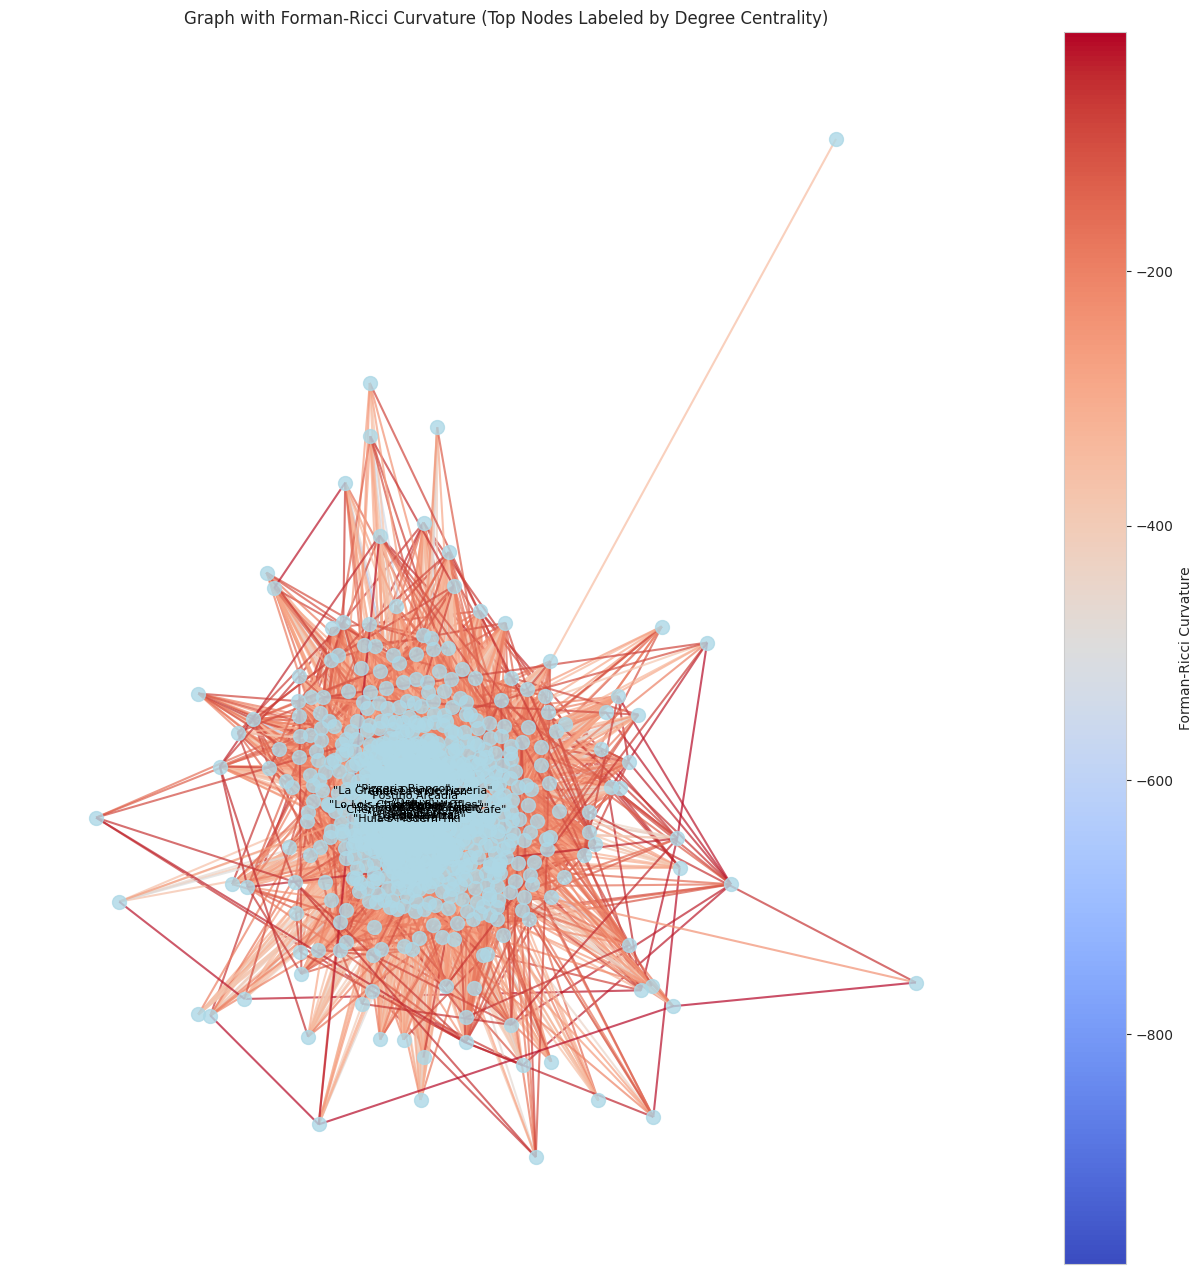

Forman-Ricci Curvature Range: -981.1333 to -11.5407
Interpretation:
 - Bright red: High positive curvature (stronger connections).
 - Bright blue: High negative curvature (weaker connections).


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx

# Ensure business_id_to_name contains mapping of original node IDs to business names
business_id_to_name = dict(zip(phoenix_businesses['business_id'], phoenix_businesses['name']))

# Map integer-labeled nodes back to their original business names
reverse_mapping = {v: k for k, v in node_mapping.items()}
for node in G_largest_cc_int.nodes:
    original_node = reverse_mapping[node]
    G_largest_cc_int.nodes[node]['label'] = business_id_to_name.get(original_node, 'Unknown')

# Extract Forman-Ricci curvature values
forman_ricci_values = nx.get_edge_attributes(G_largest_cc_int, "formanCurvature")

# Normalize curvature values for color mapping
norm_forman = mcolors.Normalize(vmin=min(forman_ricci_values.values()), vmax=max(forman_ricci_values.values()), clip=True)
cmap_forman = plt.cm.coolwarm  # Choose a colormap

# Prepare positions for nodes
pos_forman = nx.spring_layout(G_largest_cc_int, seed=42)

plt.figure(figsize=(16, 16))

# Draw nodes
nx.draw_networkx_nodes(G_largest_cc_int, pos_forman, node_size=100, node_color="lightblue", alpha=0.8)

# Draw edges with curvature-based color mapping
nx.draw_networkx_edges(
    G_largest_cc_int,
    pos_forman,
    edge_color=list(forman_ricci_values.values()),  # Use curvature values for edge color
    edge_cmap=cmap_forman,
    edge_vmin=min(forman_ricci_values.values()),
    edge_vmax=max(forman_ricci_values.values()),
    width=1.5,
    alpha=0.7,
)

# Display labels for top central nodes only (to avoid overcrowding)
node_labels = nx.get_node_attributes(G_largest_cc_int, 'label')
central_nodes = sorted(
    G_largest_cc_int.degree, key=lambda x: x[1], reverse=True
)[:20]  # Top 20 nodes by degree centrality
central_node_labels = {node: node_labels[node] for node, _ in central_nodes}
nx.draw_networkx_labels(G_largest_cc_int, pos_forman, labels=central_node_labels, font_size=8, font_color="black")

# Add colorbar tied to the edges
sm_forman = plt.cm.ScalarMappable(norm=norm_forman, cmap=cmap_forman)
sm_forman.set_array([])  # Assign empty array to ScalarMappable
plt.colorbar(sm_forman, ax=plt.gca(), label="Forman-Ricci Curvature")

# Add title and display
plt.title("Graph with Forman-Ricci Curvature (Top Nodes Labeled by Degree Centrality)")
plt.axis("off")
plt.show()

# Print curvature range and interpretation
print(f"Forman-Ricci Curvature Range: {min(forman_ricci_values.values()):.4f} to {max(forman_ricci_values.values()):.4f}")
print("Interpretation:")
print(" - Bright red: High positive curvature (stronger connections).")
print(" - Bright blue: High negative curvature (weaker connections).")


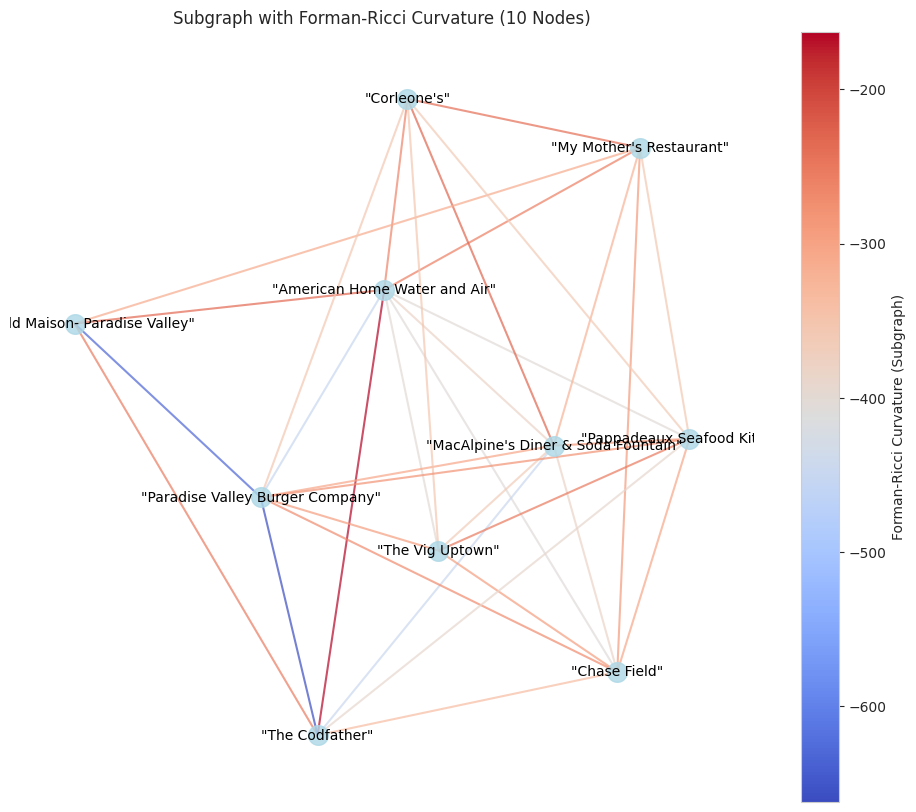

Forman-Ricci Curvature Range (Subgraph): -661.9726 to -162.8181
Interpretation:
 - Bright red: High positive curvature (stronger connections).
 - Bright blue: High negative curvature (weaker connections).


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx

# Select a subset of nodes (e.g., 10 nodes from the integer-labeled graph)
subset_nodes = list(G_largest_cc_int.nodes)[:10]  # Adjust the range as needed
G_subgraph_forman = G_largest_cc_int.subgraph(subset_nodes).copy()

# Ensure business_id_to_name contains mapping of original node IDs to business names
reverse_mapping = {v: k for k, v in node_mapping.items()}
for node in G_subgraph_forman.nodes:
    original_node = reverse_mapping[node]
    G_subgraph_forman.nodes[node]['label'] = business_id_to_name.get(original_node, 'Unknown')

# Extract Forman-Ricci curvature values for the subgraph
forman_ricci_subgraph_values = nx.get_edge_attributes(G_subgraph_forman, "formanCurvature")

# Check if Forman-Ricci curvature values are available
if not forman_ricci_subgraph_values:
    raise ValueError("No Forman-Ricci curvature values found in the subgraph! Ensure it is computed.")

# Normalize curvature values for color mapping
norm_forman = mcolors.Normalize(
    vmin=min(forman_ricci_subgraph_values.values()),
    vmax=max(forman_ricci_subgraph_values.values()),
    clip=True
)
cmap_forman = plt.cm.coolwarm  # Choose a colormap

# Prepare positions for nodes
pos_forman = nx.spring_layout(G_subgraph_forman, seed=42)

plt.figure(figsize=(12, 10))

# Draw nodes
nx.draw_networkx_nodes(G_subgraph_forman, pos_forman, node_size=200, node_color="lightblue", alpha=0.8)

# Draw edges with curvature-based color mapping
nx.draw_networkx_edges(
    G_subgraph_forman,
    pos_forman,
    edge_color=list(forman_ricci_subgraph_values.values()),  # Use curvature values for edge color
    edge_cmap=cmap_forman,
    edge_vmin=min(forman_ricci_subgraph_values.values()),
    edge_vmax=max(forman_ricci_subgraph_values.values()),
    width=1.5,
    alpha=0.7,
)

# Display all node labels (small graph, no overcrowding)
node_labels = nx.get_node_attributes(G_subgraph_forman, 'label')
nx.draw_networkx_labels(G_subgraph_forman, pos_forman, labels=node_labels, font_size=10, font_color="black")

# Add colorbar tied to the edges
sm_forman = plt.cm.ScalarMappable(norm=norm_forman, cmap=cmap_forman)
sm_forman.set_array([])  # Assign empty array to ScalarMappable
plt.colorbar(sm_forman, ax=plt.gca(), label="Forman-Ricci Curvature (Subgraph)")

# Add title and display
plt.title("Subgraph with Forman-Ricci Curvature (10 Nodes)")
plt.axis("off")
plt.show()

# Print curvature range and interpretation
print(f"Forman-Ricci Curvature Range (Subgraph): {min(forman_ricci_subgraph_values.values()):.4f} to {max(forman_ricci_subgraph_values.values()):.4f}")
print("Interpretation:")
print(" - Bright red: High positive curvature (stronger connections).")
print(" - Bright blue: High negative curvature (weaker connections).")


code to download froman ricci values which can used later


In [ ]:
import json
from google.colab import files

# Save Forman-Ricci curvature values for the entire graph
forman_ricci_file = "forman_ricci_values.json"
forman_ricci_values = nx.get_edge_attributes(G_largest_cc_int, "formanCurvature")

# Save to JSON
with open(forman_ricci_file, "w") as f:
    json.dump({str(edge): value for edge, value in forman_ricci_values.items()}, f)

print(f"Forman-Ricci curvature values saved to '{forman_ricci_file}'.")

# Download the file
files.download(forman_ricci_file)


Forman-Ricci curvature values saved to 'forman_ricci_values.json'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

code to reload later

In [ ]:
with open("forman_ricci_values.json", "r") as f:
    forman_ricci_values = json.load(f)

# Convert string keys back to tuples
forman_ricci_values = {tuple(map(int, edge.strip("()").split(", "))): value
                       for edge, value in forman_ricci_values.items()}


visualize curvature distribution

Visualizing Ollivier-Ricci curvature distribution for the whole graph...


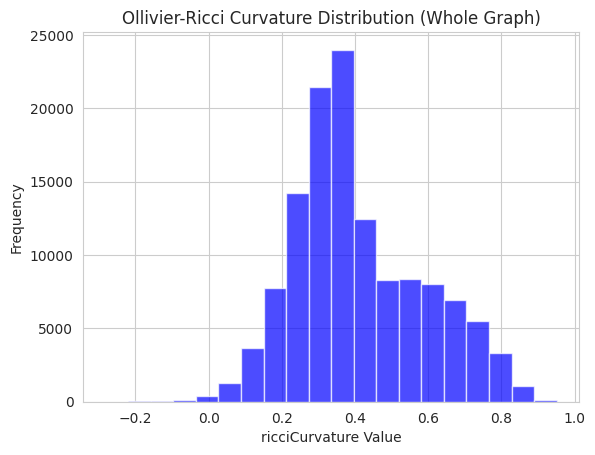

Visualizing Forman-Ricci curvature distribution for the whole graph...


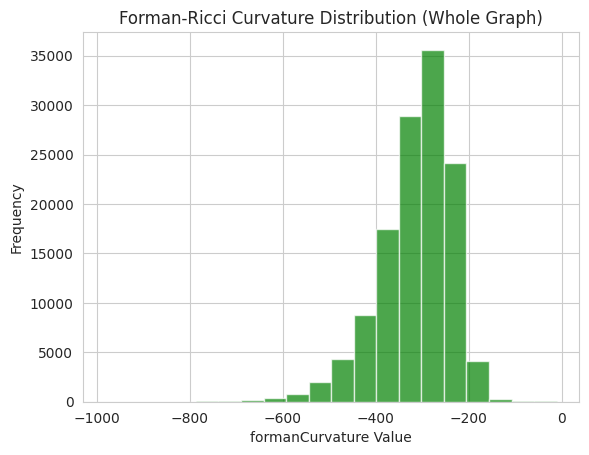

In [ ]:
import matplotlib.pyplot as plt

def visualize_curvature(graph, curvature_key, title, color):
    """
    Visualize the distribution of edge curvature values for a graph.
    """
    edge_curvatures = nx.get_edge_attributes(graph, curvature_key)
    if not edge_curvatures:
        print(f"No curvature values found for key '{curvature_key}'!")
        return

    values = list(edge_curvatures.values())
    plt.hist(values, bins=20, alpha=0.7, color=color)
    plt.xlabel(f'{curvature_key} Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

# Visualize Ollivier-Ricci curvature for the entire graph
print("Visualizing Ollivier-Ricci curvature distribution for the whole graph...")
visualize_curvature(G_largest_cc, "ricciCurvature", "Ollivier-Ricci Curvature Distribution (Whole Graph)", color="blue")

# Visualize Forman-Ricci curvature for the entire graph
print("Visualizing Forman-Ricci curvature distribution for the whole graph...")
visualize_curvature(G_largest_cc_int, "formanCurvature", "Forman-Ricci Curvature Distribution (Whole Graph)", color="green")


k means

Extracting features with Ollivier-Ricci curvature...
Extracting features with Forman-Ricci curvature...
Extracting features without Ricci curvature...
Clustering with Ollivier-Ricci...
Clustering with Forman-Ricci...
Clustering without Ricci curvature...
Mapping clusters to node names for Ollivier-Ricci...
Mapping clusters to node names for Forman-Ricci...
Mapping clusters to node names without Ricci curvature...
Visualizing clusters for Ollivier-Ricci...


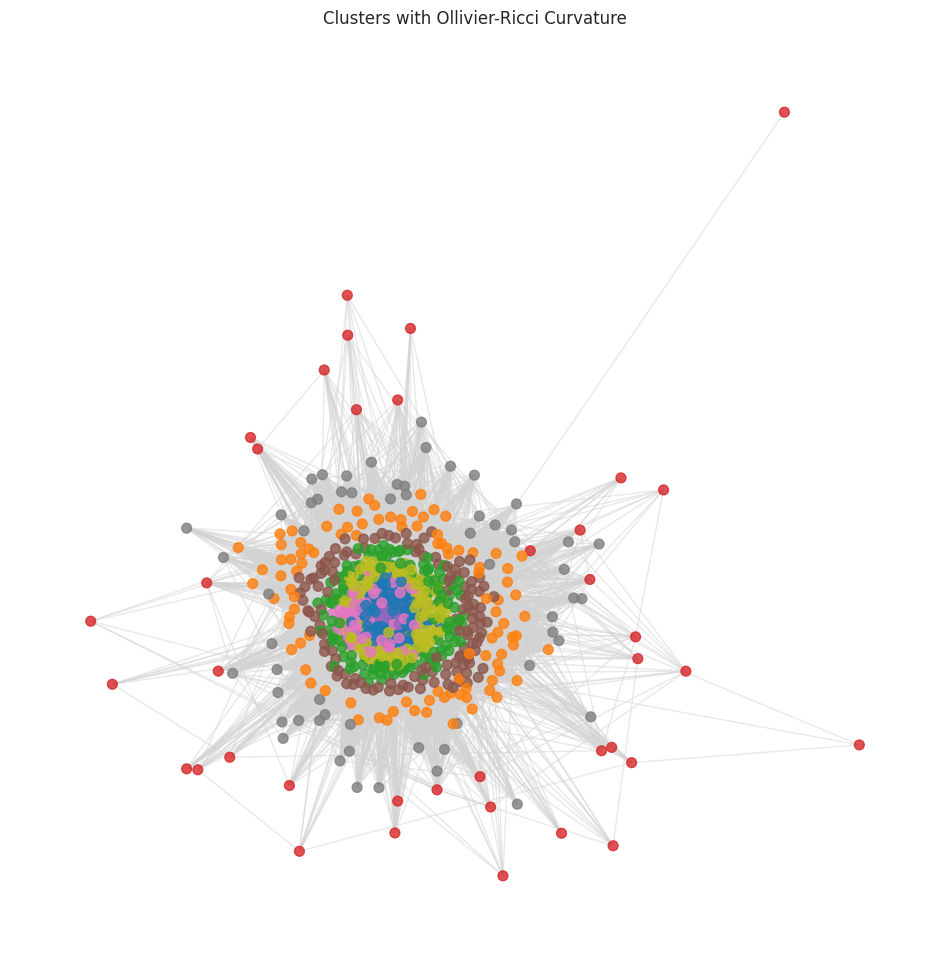

Visualizing clusters for Forman-Ricci...


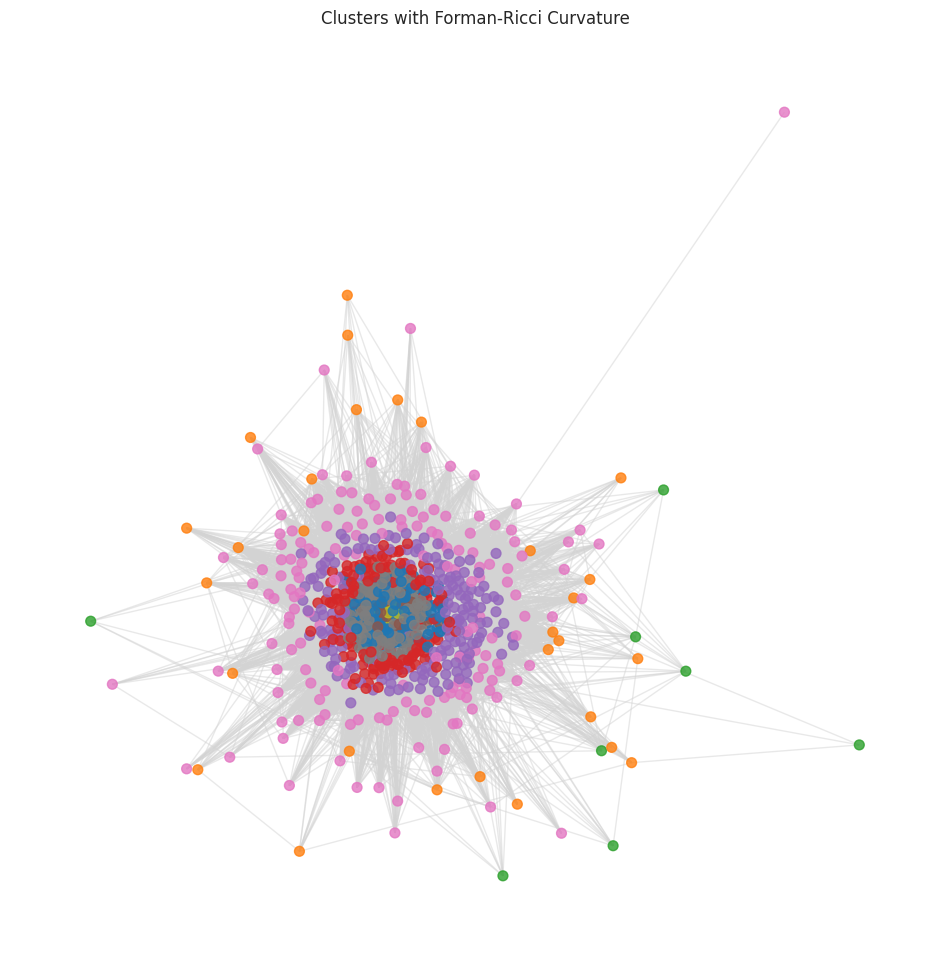

Visualizing clusters without Ricci curvature...


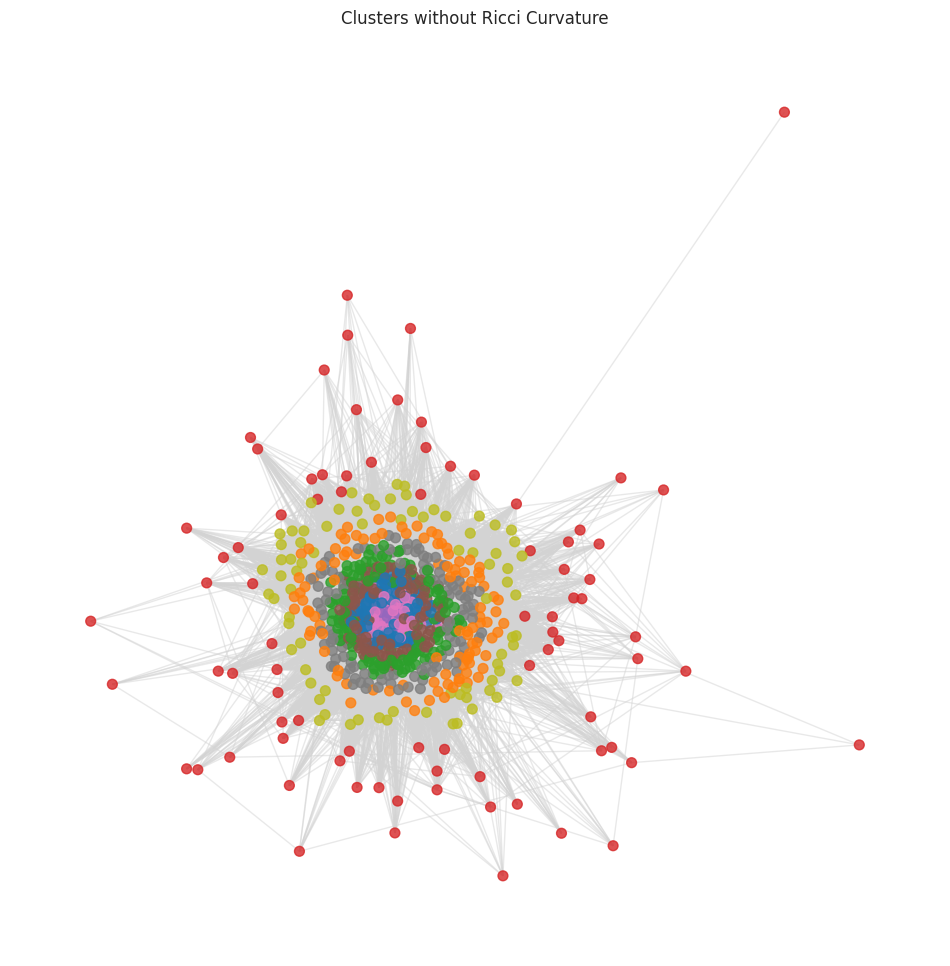


Clusters with Ollivier-Ricci Curvature
Cluster 3: "American Home Water and Air", "Garage Doors 4 Less", "All Pro Shade Concepts", "Urban Desert Pest Control", "Bulwark Exterminating", "SafePro Auto Glass", "Dan's Window Tint", "Muscular Moving Men", "George Brazil Plumbing & Electrical", "Arizona Brothers Moving and Storage"...
Cluster 8: "MacAlpine's Diner & Soda Fountain", "Smashburger", "Luci's at the Orchard", "The Habit Burger Grill", "Luke's of Chicago's", "Yard House", "Camp Social", "Aunt Chiladas Squaw Peak", "Upper Crust Pizza Patio & Wine Bar", "SOLO Trattoria"...
Cluster 0: "Chase Field", "Pappadeaux Seafood Kitchen", "Paradise Valley Burger Company", "Rocket Burger & Subs", "Pomo Pizzeria - Phoenix", "Melt", "DaVang's", "Niccoli's Italian Grocery & Deli", "Grassroots Kitchen & Tap", "The White Chocolate Grill"...
Cluster 2: "Marigold Maison- Paradise Valley", "My Mother's Restaurant", "Corleone's", "Burland Jewelry Center", "Halo-Halo Kitchen", "Viet Kitchen", "Arizona Bi

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Step 1: Extract features for clustering
def extract_features(graph, ricci_key=None):
    """
    Extract features for clustering.
    If `ricci_key` is None, use only degree centrality; otherwise, include Ricci curvature.
    """
    degree_centrality = nx.degree_centrality(graph)
    features = []

    for node in graph.nodes:
        feature = [degree_centrality[node]]
        if ricci_key is not None:
            # Compute average Ricci curvature for edges connected to the node
            edge_curvatures = [
                graph[u][v].get(ricci_key, 0) for u, v in graph.edges(node)
            ]
            avg_ricci = np.mean(edge_curvatures) if edge_curvatures else 0
            feature.append(avg_ricci)
        features.append(feature)

    return np.array(features)

# Step 2: Prepare data for each clustering scenario
print("Extracting features with Ollivier-Ricci curvature...")
features_ollivier = extract_features(G_largest_cc, ricci_key="ricciCurvature")
print("Extracting features with Forman-Ricci curvature...")
features_forman = extract_features(G_largest_cc_int, ricci_key="formanCurvature")
print("Extracting features without Ricci curvature...")
features_no_ricci = extract_features(G_largest_cc)

# Step 3: Standardize features for clustering
scaler = StandardScaler()
features_ollivier_scaled = scaler.fit_transform(features_ollivier)
features_forman_scaled = scaler.fit_transform(features_forman)
features_no_ricci_scaled = scaler.fit_transform(features_no_ricci)

# Step 4: Perform K-means clustering
def perform_kmeans(features, n_clusters=9):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    return labels, kmeans

print("Clustering with Ollivier-Ricci...")
labels_ollivier, kmeans_ollivier = perform_kmeans(features_ollivier_scaled)
print("Clustering with Forman-Ricci...")
labels_forman, kmeans_forman = perform_kmeans(features_forman_scaled)
print("Clustering without Ricci curvature...")
labels_no_ricci, kmeans_no_ricci = perform_kmeans(features_no_ricci_scaled)

# Step 5: Map cluster results to node names
def map_clusters_to_names(graph, labels, is_integer_labeled=False):
    """
    Map clustering results to node names.
    If `is_integer_labeled` is True, map integer-labeled nodes back to original names.
    """
    cluster_mapping = {}

    for node, label in zip(graph.nodes, labels):
        if is_integer_labeled:
            # Map integer-labeled node back to the original node ID
            original_node = reverse_mapping[node]
            node_name = business_id_to_name.get(original_node, "Unknown")
        else:
            # Use the business ID directly
            node_name = business_id_to_name.get(node, "Unknown")

        if label not in cluster_mapping:
            cluster_mapping[label] = []
        cluster_mapping[label].append(node_name)

    return cluster_mapping

reverse_mapping = {v: k for k, v in node_mapping.items()}

print("Mapping clusters to node names for Ollivier-Ricci...")
clusters_ollivier = map_clusters_to_names(G_largest_cc, labels_ollivier, is_integer_labeled=False)

# Fixing cluster mapping for Forman-Ricci
print("Mapping clusters to node names for Forman-Ricci...")
clusters_forman = map_clusters_to_names(G_largest_cc_int, labels_forman, is_integer_labeled=True)

# Fixing cluster mapping without Ricci
print("Mapping clusters to node names without Ricci curvature...")
clusters_no_ricci = map_clusters_to_names(G_largest_cc, labels_no_ricci, is_integer_labeled=False)

# Step 6: Visualize clusters
def visualize_clusters(graph, labels, title):
    """
    Visualize clusters using node positions and cluster labels.
    """
    pos = nx.spring_layout(graph, seed=42)
    plt.figure(figsize=(12, 12))

    # Assign colors to clusters
    cluster_colors = sns.color_palette("tab10", n_colors=len(set(labels)))
    color_map = [cluster_colors[label] for label in labels]

    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, node_color=color_map, node_size=50, alpha=0.8)
    nx.draw_networkx_edges(graph, pos, edge_color="lightgray", alpha=0.5)

    # Add title
    plt.title(title)
    plt.axis("off")
    plt.show()

print("Visualizing clusters for Ollivier-Ricci...")
visualize_clusters(G_largest_cc, labels_ollivier, "Clusters with Ollivier-Ricci Curvature")

print("Visualizing clusters for Forman-Ricci...")
visualize_clusters(G_largest_cc_int, labels_forman, "Clusters with Forman-Ricci Curvature")

print("Visualizing clusters without Ricci curvature...")
visualize_clusters(G_largest_cc, labels_no_ricci, "Clusters without Ricci Curvature")

# Print clusters (as names)
def print_clusters(cluster_mapping, title):
    print(f"\n{title}")
    for cluster, nodes in cluster_mapping.items():
        print(f"Cluster {cluster}: {', '.join(nodes[:10])}...")  # Show first 10 nodes

print_clusters(clusters_ollivier, "Clusters with Ollivier-Ricci Curvature")
print_clusters(clusters_forman, "Clusters with Forman-Ricci Curvature")
print_clusters(clusters_no_ricci, "Clusters without Ricci Curvature")


In [ ]:
# Function to print the number of nodes in each cluster
def print_cluster_sizes(cluster_mapping, title):
    print(f"\n{title}")
    for cluster, nodes in cluster_mapping.items():
        print(f"Cluster {cluster}: {len(nodes)} nodes")

# Print cluster sizes for Ollivier-Ricci
print_cluster_sizes(clusters_ollivier, "Cluster Sizes with Ollivier-Ricci Curvature")

# Print cluster sizes for Forman-Ricci
print_cluster_sizes(clusters_forman, "Cluster Sizes with Forman-Ricci Curvature")

# Print cluster sizes without Ricci curvature
print_cluster_sizes(clusters_no_ricci, "Cluster Sizes without Ricci Curvature")



Cluster Sizes with Ollivier-Ricci Curvature
Cluster 3: 38 nodes
Cluster 8: 129 nodes
Cluster 0: 126 nodes
Cluster 2: 125 nodes
Cluster 4: 50 nodes
Cluster 5: 127 nodes
Cluster 6: 71 nodes
Cluster 1: 98 nodes
Cluster 7: 58 nodes

Cluster Sizes with Forman-Ricci Curvature
Cluster 1: 29 nodes
Cluster 7: 132 nodes
Cluster 5: 47 nodes
Cluster 4: 182 nodes
Cluster 3: 137 nodes
Cluster 0: 104 nodes
Cluster 6: 166 nodes
Cluster 2: 8 nodes
Cluster 8: 17 nodes

Cluster Sizes without Ricci Curvature
Cluster 3: 82 nodes
Cluster 5: 115 nodes
Cluster 6: 64 nodes
Cluster 7: 107 nodes
Cluster 2: 133 nodes
Cluster 4: 34 nodes
Cluster 0: 104 nodes
Cluster 1: 104 nodes
Cluster 8: 79 nodes


this section gives the business id and the reviews for bsuiness in the clusters in the above it gives the names rather

In [ ]:
def map_clusters_to_ids_and_text(graph, labels, review_data, is_integer_labeled=False):
    """
    Map clustering results to business IDs and their associated review texts.
    If `is_integer_labeled` is True, map integer-labeled nodes back to original IDs.
    """
    cluster_mapping = {}

    for node, label in zip(graph.nodes, labels):
        if is_integer_labeled:
            # Map integer-labeled node back to the original node ID
            original_node = reverse_mapping[node]
            business_id = original_node
        else:
            business_id = node

        # Get review texts and business IDs from review_data
        reviews = review_data[review_data['business_id'] == business_id]

        if label not in cluster_mapping:
            cluster_mapping[label] = []

        # Add (business_id, text) tuples
        cluster_mapping[label].extend(
            reviews[['business_id', 'text']].to_records(index=False)
        )

    return cluster_mapping


# Map clusters to business IDs and texts for each scenario
print("Mapping clusters with Ollivier-Ricci to business IDs and texts...")
clusters_ollivier_texts = map_clusters_to_ids_and_text(
    G_largest_cc, labels_ollivier, filtered_reviews, is_integer_labeled=False
)

print("Mapping clusters with Forman-Ricci to business IDs and texts...")
clusters_forman_texts = map_clusters_to_ids_and_text(
    G_largest_cc_int, labels_forman, filtered_reviews, is_integer_labeled=True
)

print("Mapping clusters without Ricci curvature to business IDs and texts...")
clusters_no_ricci_texts = map_clusters_to_ids_and_text(
    G_largest_cc, labels_no_ricci, filtered_reviews, is_integer_labeled=False
)

# Print clusters (as business IDs and texts)
def print_clusters_with_text(cluster_mapping, title):
    print(f"\n{title}")
    for cluster, nodes in cluster_mapping.items():
        print(f"Cluster {cluster}:")
        for business_id, text in nodes[:5]:  # Show first 5 businesses and texts
            print(f"  Business ID: {business_id}")
            print(f"  Text: {text[:100]}...")  # Show first 100 characters of the review text
        print("...")

print_clusters_with_text(clusters_ollivier_texts, "Clusters with Ollivier-Ricci Curvature")
print_clusters_with_text(clusters_forman_texts, "Clusters with Forman-Ricci Curvature")
print_clusters_with_text(clusters_no_ricci_texts, "Clusters without Ricci Curvature")


Mapping clusters with Ollivier-Ricci to business IDs and texts...
Mapping clusters with Forman-Ricci to business IDs and texts...
Mapping clusters without Ricci curvature to business IDs and texts...

Clusters with Ollivier-Ricci Curvature
Cluster 3:
  Business ID: lsHmnOZNlsKnEDsNmT-5_Q
  Text: American Home Water just installed a 50 gallon Bradford White water heater for me. They were fantast...
  Business ID: lsHmnOZNlsKnEDsNmT-5_Q
  Text: 5 star service from Brad and American. Zero pressure from this company and they actually provided qu...
  Business ID: lsHmnOZNlsKnEDsNmT-5_Q
  Text: Fidel and Tyler changed out my RO filters and hooked up my ice machine line today. Both very profess...
  Business ID: lsHmnOZNlsKnEDsNmT-5_Q
  Text: I appreciate the service provided by American Home Water and Air. I have found this company to be re...
  Business ID: lsHmnOZNlsKnEDsNmT-5_Q
  Text: I used this company for a water softener installation, and now a hot water heater and recirculating ...

In [ ]:
import pandas as pd
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
import nltk

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # Download the 'punkt_tab' resource

# Preprocessing function for reviews
def preprocess_reviews(text):
    """
    Preprocesses review text: tokenizes, removes stopwords, and stems words.
    """
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()

    # Tokenize, remove stopwords, and stem words
    tokens = word_tokenize(text.lower())
    tokens = [ps.stem(word) for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

# Step 1: Calculate normalized word counts per business
def calculate_normalized_counts(reviews_df):
    """
    Calculate normalized word counts for each business.
    """
    business_word_counts = {}
    business_review_counts = reviews_df['business_id'].value_counts()

    for business_id, group in reviews_df.groupby('business_id'):
        # Combine all reviews for a business
        combined_text = " ".join(group['text'])
        tokens = preprocess_reviews(combined_text)

        # Frequency distribution of words
        word_freq = FreqDist(tokens)
        total_reviews = business_review_counts[business_id]

        # Normalized count for each word
        business_word_counts[business_id] = {word: count / total_reviews for word, count in word_freq.items()}

    return business_word_counts

# Step 2: Aggregate normalized counts at the cluster level
def calculate_cluster_word_counts(cluster_mapping, business_word_counts):
    """
    Aggregate normalized word counts at the cluster level.
    """
    cluster_word_counts = defaultdict(lambda: defaultdict(float))

    for cluster_id, business_ids in cluster_mapping.items():
        for business_id_record in business_ids:  # business_ids now contains records
            business_id = business_id_record[0]  # Extract the business_id from the record
            word_counts = business_word_counts.get(business_id, {})
            for word, norm_count in word_counts.items():
                cluster_word_counts[cluster_id][word] += norm_count

    return cluster_word_counts

# Step 3: Extract top 10 words for each cluster
def get_top_words(cluster_word_counts, top_n=10):
    """
    Get the top N words for each cluster.
    """
    cluster_top_words = {}
    for cluster_id, word_counts in cluster_word_counts.items():
        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        cluster_top_words[cluster_id] = sorted_words[:top_n]
    return cluster_top_words

# Example Usage
# Assuming `filtered_reviews` contains `business_id` and `text`, and `clusters_ollivier` maps cluster IDs to business IDs
print("Calculating normalized word counts...")
business_word_counts = calculate_normalized_counts(filtered_reviews)

print("Aggregating word counts at the cluster level...")
cluster_word_counts_ollivier = calculate_cluster_word_counts(clusters_ollivier_texts, business_word_counts)

print("Extracting top words for clusters...")
top_words_ollivier = get_top_words(cluster_word_counts_ollivier)

# Display the results
def display_cluster_top_words(top_words, title):
    print(f"\nTop Words for {title}:")
    for cluster_id, words in top_words.items():
        print(f"Cluster {cluster_id}:")
        for word, count in words:
            print(f"  {word}: {count:.4f}")
        print()

display_cluster_top_words(top_words_ollivier, "Ollivier-Ricci Clusters")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Calculating normalized word counts...
Aggregating word counts at the cluster level...
Extracting top words for clusters...

Top Words for Ollivier-Ricci Clusters:
Cluster 3:
  servic: 3390.0000
  time: 3284.0000
  great: 3267.0000
  call: 2631.0000
  would: 2459.0000
  work: 2408.0000
  recommend: 2295.0000
  move: 2285.0000
  compani: 2265.0000
  use: 2152.0000

Cluster 8:
  place: 19403.0000
  food: 18758.0000
  great: 18435.0000
  good: 17050.0000
  time: 10693.0000
  go: 9889.0000
  servic: 9855.0000
  like: 9767.0000
  love: 9735.0000
  order: 9699.0000

Cluster 0:
  place: 31425.0000
  food: 28692.0000
  great: 27594.0000
  good: 26089.0000
  like: 17242.0000
  time: 16993.0000
  love: 16523.0000
  go: 16131.0000
  get: 15204.0000
  order: 14894.0000

Cluster 2:
  place: 15602.0000
  food: 15483.0000
  great: 13515.0000
  good: 12957.0000
  servic: 7882.0000
  time: 7879.0000
  love: 7785.0000
  like: 7656.0000
  go: 7388.0000
  order: 7164.0000

Cluster 4:
  place: 25506.0000
  

use the topic modelling to identify the theme

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing function for reviews
def preprocess_reviews(reviews):
    """
    Preprocess reviews by removing stopwords, punctuation, and lemmatizing words.
    """
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    def clean_text(text):
        # Remove punctuation and lowercase text
        text = text.lower().translate(str.maketrans('', '', string.punctuation))
        # Tokenize and remove stopwords
        tokens = [word for word in text.split() if word not in stop_words]
        # Lemmatize tokens
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        return ' '.join(tokens)

    return reviews.apply(clean_text)

# Apply LDA for each cluster
def apply_lda_for_clusters(cluster_texts, num_topics=3, num_words=10):
    """
    Apply LDA topic modeling to each cluster and extract topics.

    Parameters:
        cluster_texts: dict {cluster_id: DataFrame of reviews for each cluster}
        num_topics: Number of topics to extract for each cluster
        num_words: Number of words per topic

    Returns:
        topics_per_cluster: dict {cluster_id: list of topics for each cluster}
    """
    topics_per_cluster = {}

    for cluster_id, reviews_df in cluster_texts.items():
        if reviews_df.empty:
            topics_per_cluster[cluster_id] = ["No topics due to lack of data."]
            continue

        # Preprocess reviews
        processed_reviews = preprocess_reviews(reviews_df['text'])

        # Create document-term matrix
        vectorizer = CountVectorizer(max_df=0.9, min_df=2)
        dt_matrix = vectorizer.fit_transform(processed_reviews)
        vocab = vectorizer.get_feature_names_out()

        # Apply LDA
        lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda_model.fit(dt_matrix)

        # Extract topics
        topics = []
        for topic_idx, topic in enumerate(lda_model.components_):
            top_words = [vocab[i] for i in topic.argsort()[-num_words:][::-1]]
            topics.append(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

        topics_per_cluster[cluster_id] = topics

    return topics_per_cluster

# Example: Apply LDA to all clusters
def prepare_cluster_texts(filtered_reviews, clusters_mapping):
    """
    Prepare a dictionary mapping cluster IDs to DataFrames of their reviews.
    """
    cluster_texts = {}
    for cluster_id, business_ids in clusters_mapping.items():
        cluster_texts[cluster_id] = filtered_reviews[
            filtered_reviews['business_id'].isin([b_id[0] for b_id in business_ids])
        ]
    return cluster_texts

# Map clusters to texts (example with Ollivier-Ricci clusters)
print("Preparing cluster texts...")
cluster_texts_ollivier = prepare_cluster_texts(filtered_reviews, clusters_ollivier_texts)

print("Applying LDA to all clusters...")
lda_topics_ollivier = apply_lda_for_clusters(cluster_texts_ollivier)

# Display topics for all clusters
def display_topics_for_clusters(topics_per_cluster, title):
    print(f"\n{title}")
    for cluster_id, topics in topics_per_cluster.items():
        print(f"\nCluster {cluster_id}:")
        for topic in topics:
            print(f"  {topic}")

display_topics_for_clusters(lda_topics_ollivier, "LDA Topics for Ollivier-Ricci Clusters")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Preparing cluster texts...
Applying LDA to all clusters...

LDA Topics for Ollivier-Ricci Clusters

Cluster 2:
  Topic 1: water, company, heater, home, price, would, air, unit, service, tom
  Topic 2: system, water, service, home, ac, company, ro, unit, time, american
  Topic 3: water, great, company, softener, called, heater, system, time, day, home

Cluster 8:
  Topic 1: soda, cream, place, ice, good, old, food, like, great, back
  Topic 2: place, great, food, good, like, soda, cream, salad, ice, love
  Topic 3: soda, cream, place, ice, great, fountain, food, macalpines, time, store

Cluster 0:
  Topic 1: game, great, food, field, stadium, seat, chase, baseball, park, ballpark
  Topic 2: stadium, game, field, baseball, chase, great, fan, like, seat, food
  Topic 3: field, fan, game, chase, park, great, get, ballpark, go, food

Cluster 7:
  Topic 1: food, indian, great, place, chicken, restaurant, good, service, naan, time
  Topic 2: food, indian, love, delicious, best, good, back, gr

Spectral Clustering

Spectral clustering with Ollivier-Ricci...
Spectral clustering with Forman-Ricci...
Spectral clustering without Ricci curvature...
Mapping spectral clusters to node names for Ollivier-Ricci...
Mapping spectral clusters to node names for Forman-Ricci...
Mapping spectral clusters to node names without Ricci curvature...
Visualizing spectral clusters for Ollivier-Ricci...


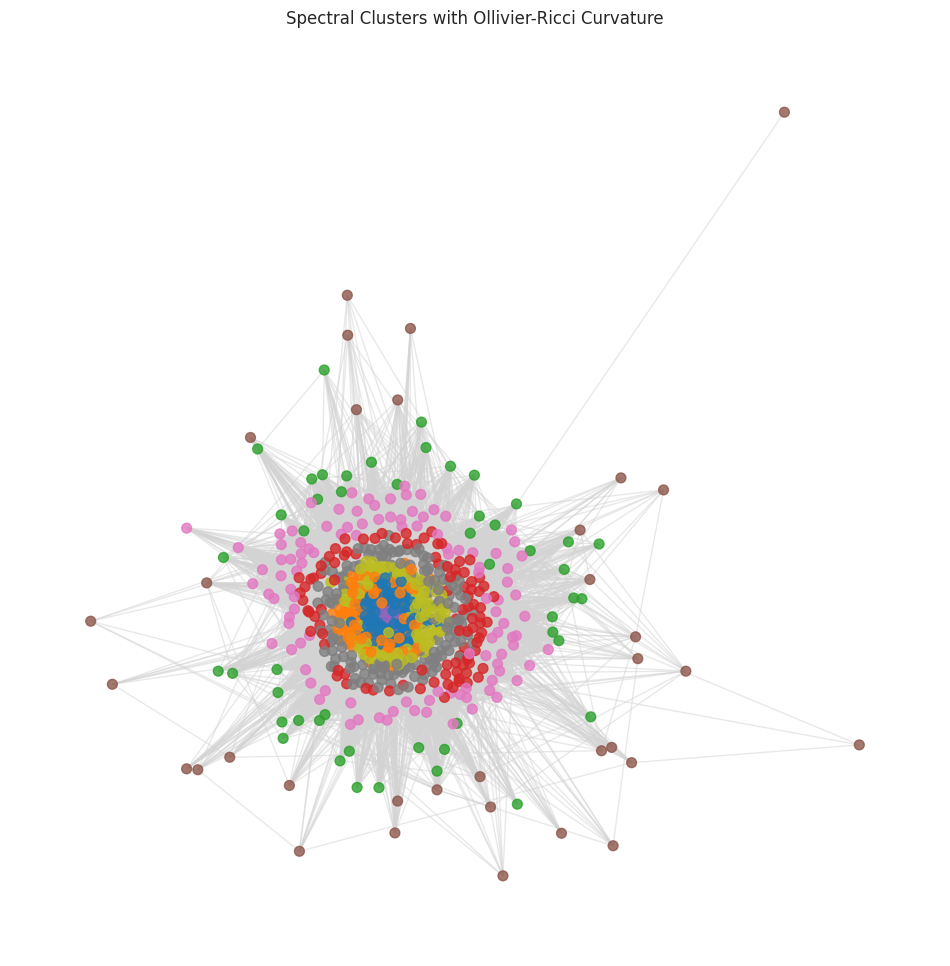

Visualizing spectral clusters for Forman-Ricci...


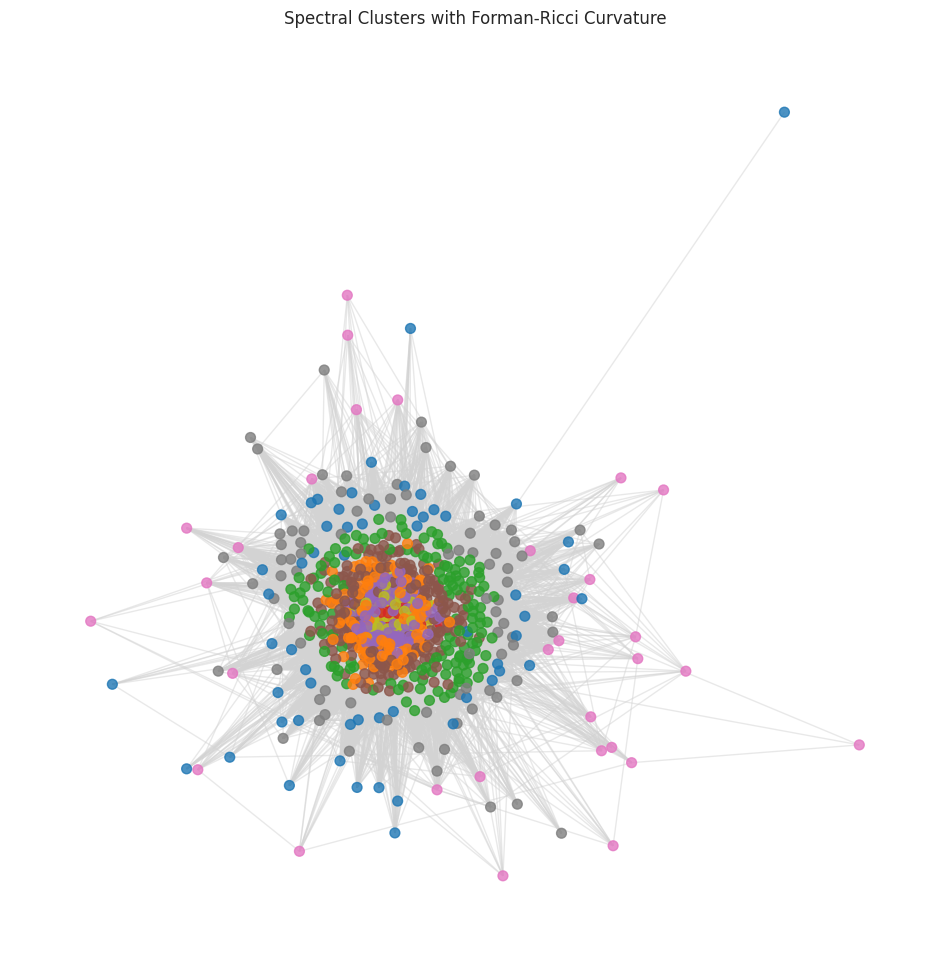

Visualizing spectral clusters without Ricci curvature...


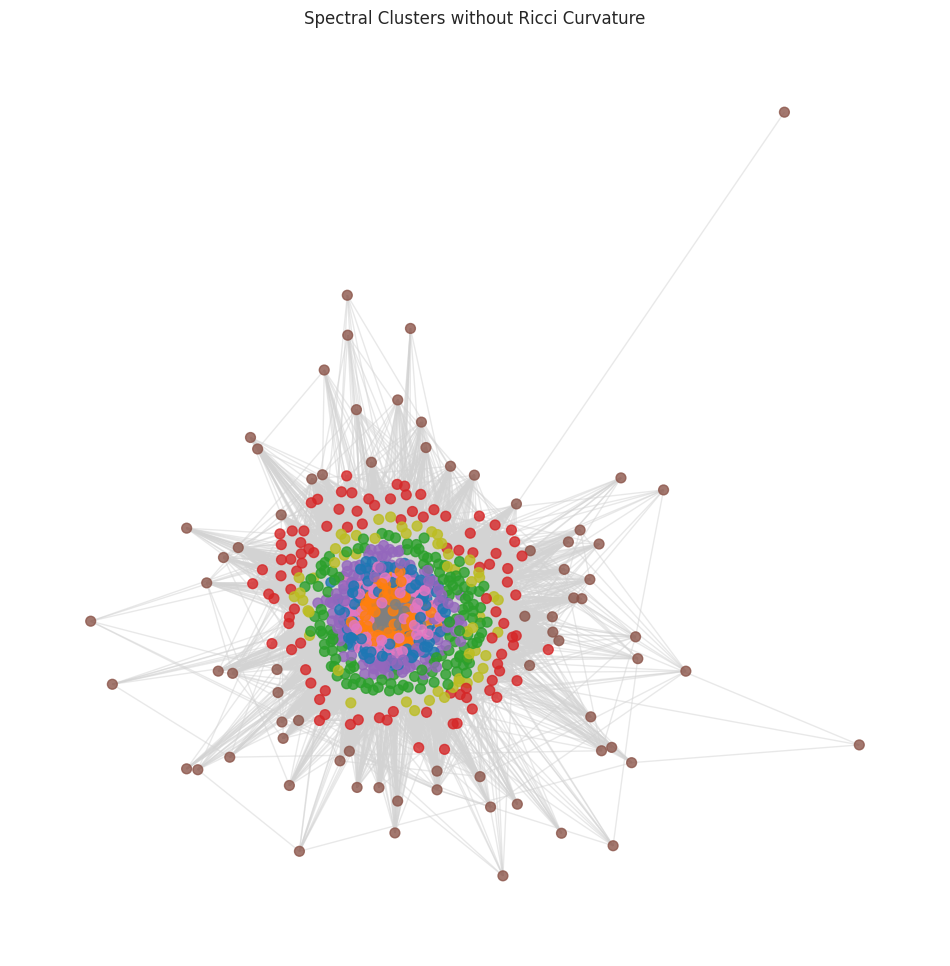


Spectral Cluster Sizes with Ollivier-Ricci Curvature
Cluster 2: 49 nodes
Cluster 8: 115 nodes
Cluster 0: 145 nodes
Cluster 7: 151 nodes
Cluster 4: 36 nodes
Cluster 3: 99 nodes
Cluster 1: 86 nodes
Cluster 5: 34 nodes
Cluster 6: 107 nodes

Spectral Cluster Sizes with Forman-Ricci Curvature
Cluster 6: 31 nodes
Cluster 1: 105 nodes
Cluster 8: 63 nodes
Cluster 5: 188 nodes
Cluster 3: 33 nodes
Cluster 2: 146 nodes
Cluster 4: 116 nodes
Cluster 7: 82 nodes
Cluster 0: 58 nodes

Spectral Cluster Sizes without Ricci Curvature
Cluster 5: 73 nodes
Cluster 6: 85 nodes
Cluster 7: 74 nodes
Cluster 4: 112 nodes
Cluster 1: 103 nodes
Cluster 8: 55 nodes
Cluster 0: 94 nodes
Cluster 2: 129 nodes
Cluster 3: 97 nodes


In [ ]:
from sklearn.cluster import SpectralClustering

# Step 1: Perform Spectral Clustering
def perform_spectral_clustering(features, n_clusters=9):
    spectral = SpectralClustering(
        n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42
    )
    labels = spectral.fit_predict(features)
    return labels

print("Spectral clustering with Ollivier-Ricci...")
labels_spectral_ollivier = perform_spectral_clustering(features_ollivier_scaled)

print("Spectral clustering with Forman-Ricci...")
labels_spectral_forman = perform_spectral_clustering(features_forman_scaled)

print("Spectral clustering without Ricci curvature...")
labels_spectral_no_ricci = perform_spectral_clustering(features_no_ricci_scaled)

# Step 2: Map cluster results to node names
print("Mapping spectral clusters to node names for Ollivier-Ricci...")
spectral_clusters_ollivier = map_clusters_to_names(
    G_largest_cc, labels_spectral_ollivier, is_integer_labeled=False
)

print("Mapping spectral clusters to node names for Forman-Ricci...")
spectral_clusters_forman = map_clusters_to_names(
    G_largest_cc_int, labels_spectral_forman, is_integer_labeled=True
)

print("Mapping spectral clusters to node names without Ricci curvature...")
spectral_clusters_no_ricci = map_clusters_to_names(
    G_largest_cc, labels_spectral_no_ricci, is_integer_labeled=False
)

# Step 3: Visualize Spectral Clustering Results
print("Visualizing spectral clusters for Ollivier-Ricci...")
visualize_clusters(
    G_largest_cc, labels_spectral_ollivier, "Spectral Clusters with Ollivier-Ricci Curvature"
)

print("Visualizing spectral clusters for Forman-Ricci...")
visualize_clusters(
    G_largest_cc_int, labels_spectral_forman, "Spectral Clusters with Forman-Ricci Curvature"
)

print("Visualizing spectral clusters without Ricci curvature...")
visualize_clusters(
    G_largest_cc, labels_spectral_no_ricci, "Spectral Clusters without Ricci Curvature"
)

# Step 4: Print the cluster sizes for spectral clustering
print_cluster_sizes(spectral_clusters_ollivier, "Spectral Cluster Sizes with Ollivier-Ricci Curvature")
print_cluster_sizes(spectral_clusters_forman, "Spectral Cluster Sizes with Forman-Ricci Curvature")
print_cluster_sizes(spectral_clusters_no_ricci, "Spectral Cluster Sizes without Ricci Curvature")


In [ ]:
def map_clusters_to_ids_and_text(graph, labels, review_data, is_integer_labeled=False):
    """
    Map clustering results to business IDs and their associated review texts.
    If `is_integer_labeled` is True, map integer-labeled nodes back to original IDs.
    """
    cluster_mapping = {}

    for node, label in zip(graph.nodes, labels):
        if is_integer_labeled:
            # Map integer-labeled node back to the original node ID
            original_node = reverse_mapping[node]
            business_id = original_node
        else:
            business_id = node

        # Get review texts and business IDs from review_data
        reviews = review_data[review_data['business_id'] == business_id]

        if label not in cluster_mapping:
            cluster_mapping[label] = []

        # Add (business_id, text) tuples
        cluster_mapping[label].extend(
            reviews[['business_id', 'text']].to_records(index=False)
        )

    return cluster_mapping


# Map clusters to business IDs and texts for each scenario
print("Mapping clusters with Ollivier-Ricci to business IDs and texts...")
spectral_clusters_ollivier_texts = map_clusters_to_ids_and_text(
    G_largest_cc, spectral_clusters_ollivier, filtered_reviews, is_integer_labeled=False
)

print("Mapping clusters with Forman-Ricci to business IDs and texts...")
spectral_clusters_forman_texts = map_clusters_to_ids_and_text(
    G_largest_cc_int, spectral_clusters_forman, filtered_reviews, is_integer_labeled=True
)

print("Mapping clusters without Ricci curvature to business IDs and texts...")
spectral_clusters_no_ricci_texts = map_clusters_to_ids_and_text(
    G_largest_cc, spectral_clusters_no_ricci, filtered_reviews, is_integer_labeled=False
)

# Print clusters (as business IDs and texts)
def print_clusters_with_text(cluster_mapping, title):
    print(f"\n{title}")
    for cluster, nodes in cluster_mapping.items():
        print(f"Cluster {cluster}:")
        for business_id, text in nodes[:5]:  # Show first 5 businesses and texts
            print(f"  Business ID: {business_id}")
            print(f"  Text: {text[:100]}...")  # Show first 100 characters of the review text
        print("...")

print_clusters_with_text(spectral_clusters_ollivier_texts, "Clusters with Ollivier-Ricci Curvature")
print_clusters_with_text(spectral_clusters_forman_texts, "Clusters with Forman-Ricci Curvature")
print_clusters_with_text(spectral_clusters_no_ricci_texts, "Clusters without Ricci Curvature")


Mapping clusters with Ollivier-Ricci to business IDs and texts...
Mapping clusters with Forman-Ricci to business IDs and texts...
Mapping clusters without Ricci curvature to business IDs and texts...

Clusters with Ollivier-Ricci Curvature
Cluster 2:
  Business ID: lsHmnOZNlsKnEDsNmT-5_Q
  Text: American Home Water just installed a 50 gallon Bradford White water heater for me. They were fantast...
  Business ID: lsHmnOZNlsKnEDsNmT-5_Q
  Text: 5 star service from Brad and American. Zero pressure from this company and they actually provided qu...
  Business ID: lsHmnOZNlsKnEDsNmT-5_Q
  Text: Fidel and Tyler changed out my RO filters and hooked up my ice machine line today. Both very profess...
  Business ID: lsHmnOZNlsKnEDsNmT-5_Q
  Text: I appreciate the service provided by American Home Water and Air. I have found this company to be re...
  Business ID: lsHmnOZNlsKnEDsNmT-5_Q
  Text: I used this company for a water softener installation, and now a hot water heater and recirculating ...

In [ ]:
import pandas as pd
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
import nltk

# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Preprocessing function for reviews
def preprocess_reviews(text):
    """
    Preprocesses review text: tokenizes, removes stopwords, and stems words.
    """
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()

    # Tokenize, remove stopwords, and stem words
    tokens = word_tokenize(text.lower())
    tokens = [ps.stem(word) for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

# Step 1: Map clusters to business IDs and texts
def map_clusters_to_ids_and_text(graph, labels, review_data, is_integer_labeled=False):
    """
    Map clustering results to business IDs and their associated review texts.
    """
    cluster_mapping = {}

    for node, label in zip(graph.nodes, labels):
        business_id = node
        reviews = review_data[review_data['business_id'] == business_id]

        if label not in cluster_mapping:
            cluster_mapping[label] = []

        # Add (business_id, text) tuples
        cluster_mapping[label].extend(
            reviews[['business_id', 'text']].to_records(index=False)
        )

    return cluster_mapping

# Map clusters to business IDs and texts for Spectral Clustering
print("Mapping Spectral Clustering results to business IDs and texts...")
spectral_clusters_texts = map_clusters_to_ids_and_text(
    G_largest_cc, labels_spectral_ollivier, filtered_reviews, is_integer_labeled=False
)

# Step 2: Calculate normalized word counts per business
def calculate_normalized_counts(reviews_df):
    """
    Calculate normalized word counts for each business.
    """
    business_word_counts = {}
    business_review_counts = reviews_df['business_id'].value_counts()

    for business_id, group in reviews_df.groupby('business_id'):
        combined_text = " ".join(group['text'])
        tokens = preprocess_reviews(combined_text)

        # Frequency distribution of words
        word_freq = FreqDist(tokens)
        total_reviews = business_review_counts[business_id]

        # Normalized count for each word
        business_word_counts[business_id] = {word: count / total_reviews for word, count in word_freq.items()}

    return business_word_counts

print("Calculating normalized word counts for Spectral Clustering...")
business_word_counts = calculate_normalized_counts(filtered_reviews)

# Step 3: Aggregate normalized counts at the cluster level
def calculate_cluster_word_counts(cluster_mapping, business_word_counts):
    """
    Aggregate normalized word counts at the cluster level.
    """
    cluster_word_counts = defaultdict(lambda: defaultdict(float))

    for cluster_id, business_ids in cluster_mapping.items():
        for business_id_record in business_ids:
            business_id = business_id_record[0]  # Extract the business_id
            word_counts = business_word_counts.get(business_id, {})
            for word, norm_count in word_counts.items():
                cluster_word_counts[cluster_id][word] += norm_count

    return cluster_word_counts

print("Aggregating word counts for Spectral Clustering...")
cluster_word_counts_spectral = calculate_cluster_word_counts(spectral_clusters_texts, business_word_counts)

# Step 4: Extract top 10 words for each cluster
def get_top_words(cluster_word_counts, top_n=10):
    """
    Get the top N words for each cluster.
    """
    cluster_top_words = {}
    for cluster_id, word_counts in cluster_word_counts.items():
        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        cluster_top_words[cluster_id] = sorted_words[:top_n]
    return cluster_top_words

print("Extracting top words for Spectral Clustering...")
top_words_spectral = get_top_words(cluster_word_counts_spectral)

# Display the results
def display_cluster_top_words(top_words, title):
    print(f"\nTop Words for {title}:")
    for cluster_id, words in top_words.items():
        print(f"Cluster {cluster_id}:")
        for word, count in words:
            print(f"  {word}: {count:.4f}")
        print()

display_cluster_top_words(top_words_spectral, "Spectral Clustering Results")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Mapping Spectral Clustering results to business IDs and texts...
Calculating normalized word counts for Spectral Clustering...
Aggregating word counts for Spectral Clustering...
Extracting top words for Spectral Clustering...

Top Words for Spectral Clustering Results:
Cluster 2:
  great: 4197.0000
  servic: 4113.0000
  time: 4017.0000
  work: 2954.0000
  call: 2696.0000
  would: 2623.0000
  get: 2577.0000
  car: 2478.0000
  recommend: 2338.0000
  good: 2032.0000

Cluster 8:
  place: 18598.0000
  food: 18478.0000
  great: 17341.0000
  good: 16265.0000
  time: 10112.0000
  order: 9454.0000
  servic: 9437.0000
  go: 9412.0000
  love: 9352.0000
  like: 9282.0000

Cluster 0:
  place: 36755.0000
  food: 33235.0000
  great: 32949.0000
  good: 30565.0000
  like: 20545.0000
  time: 20159.0000
  love: 19501.0000
  go: 18904.0000
  get: 18195.0000
  order: 17214.0000

Cluster 7:
  food: 17862.0000
  place: 17858.0000
  great: 15881.0000
  good: 15044.0000
  servic: 9469.0000
  time: 9320.0000
  

Topic Modleing using LDA to identify theme

In [ ]:
# Map clusters to texts for Spectral Clustering
print("Preparing cluster texts for Spectral Clustering...")
cluster_texts_spectral = prepare_cluster_texts(filtered_reviews, spectral_clusters_ollivier_texts)

print("Applying LDA to all Spectral Clusters...")
lda_topics_spectral = apply_lda_for_clusters(cluster_texts_spectral)

# Display topics for all clusters
display_topics_for_clusters(lda_topics_spectral, "LDA Topics for Spectral Clusters")


Preparing cluster texts for Spectral Clustering...
Applying LDA to all Spectral Clusters...

LDA Topics for Spectral Clusters

Cluster 2:
  Topic 1: water, company, heater, home, price, would, air, unit, service, tom
  Topic 2: system, water, service, home, ac, company, ro, unit, time, american
  Topic 3: water, great, company, softener, called, heater, system, time, day, home

Cluster 8:
  Topic 1: soda, cream, place, ice, good, old, food, like, great, back
  Topic 2: place, great, food, good, like, soda, cream, salad, ice, love
  Topic 3: soda, cream, place, ice, great, fountain, food, macalpines, time, store

Cluster 0:
  Topic 1: game, great, food, field, stadium, seat, chase, baseball, park, ballpark
  Topic 2: stadium, game, field, baseball, chase, great, fan, like, seat, food
  Topic 3: field, fan, game, chase, park, great, get, ballpark, go, food

Cluster 7:
  Topic 1: food, indian, great, place, chicken, restaurant, good, service, naan, time
  Topic 2: food, indian, love, deli

hierarchical clustering

Hierarchical clustering with Ollivier-Ricci...
Hierarchical clustering with Forman-Ricci...
Hierarchical clustering without Ricci curvature...
Mapping hierarchical clusters to node names for Ollivier-Ricci...
Mapping hierarchical clusters to node names for Forman-Ricci...
Mapping hierarchical clusters to node names without Ricci curvature...
Plotting dendrogram for Ollivier-Ricci...


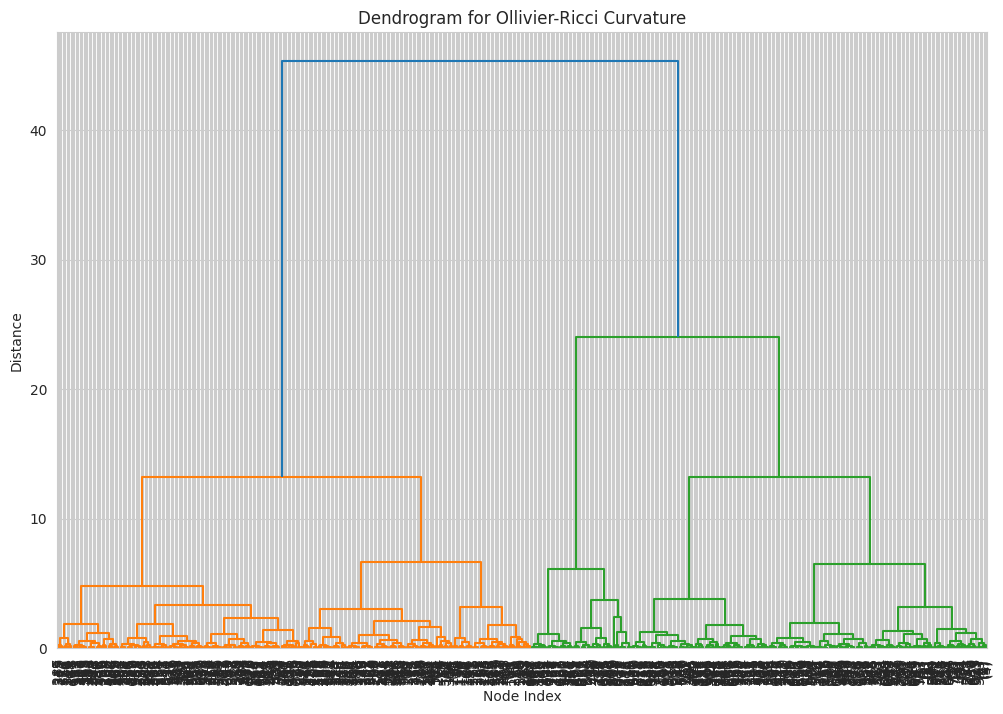

Plotting dendrogram for Forman-Ricci...


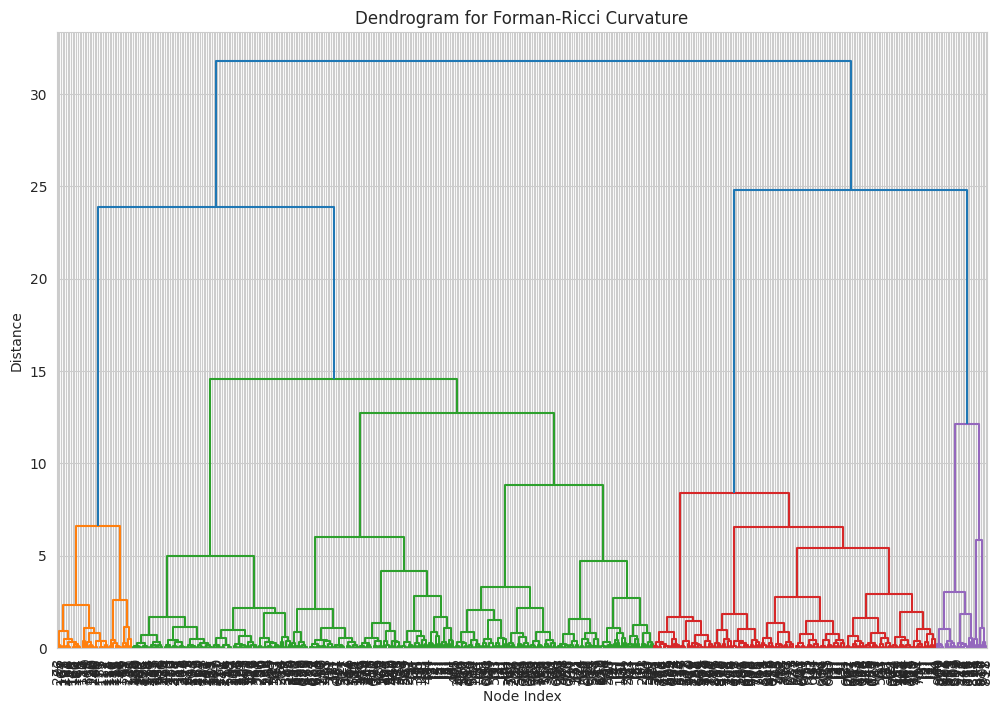

Plotting dendrogram without Ricci curvature...


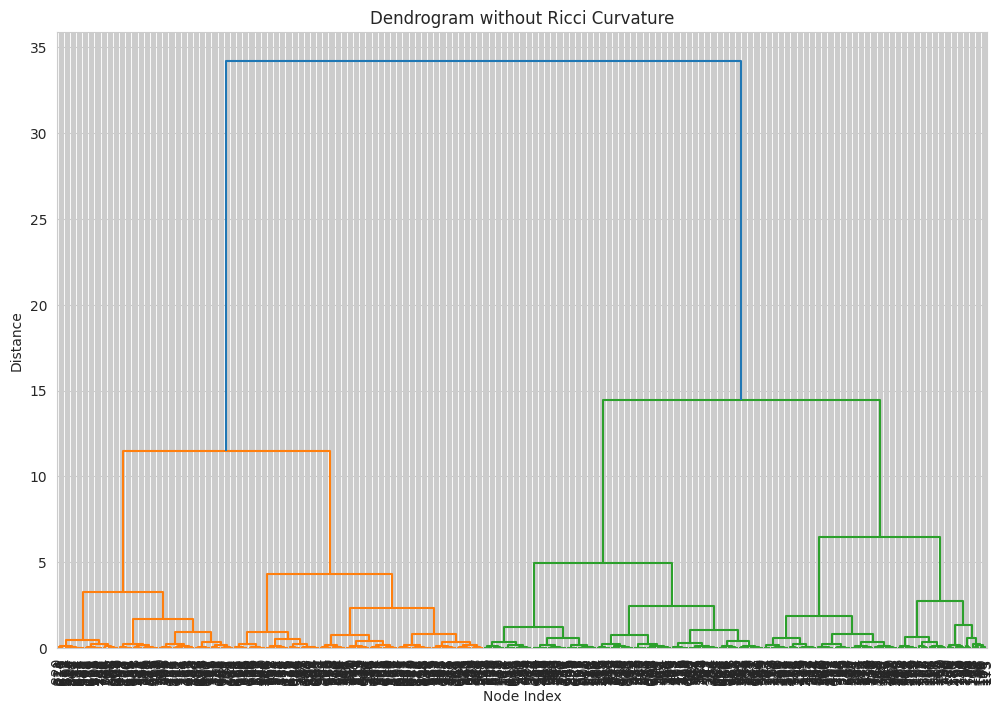

Visualizing hierarchical clusters for Ollivier-Ricci...


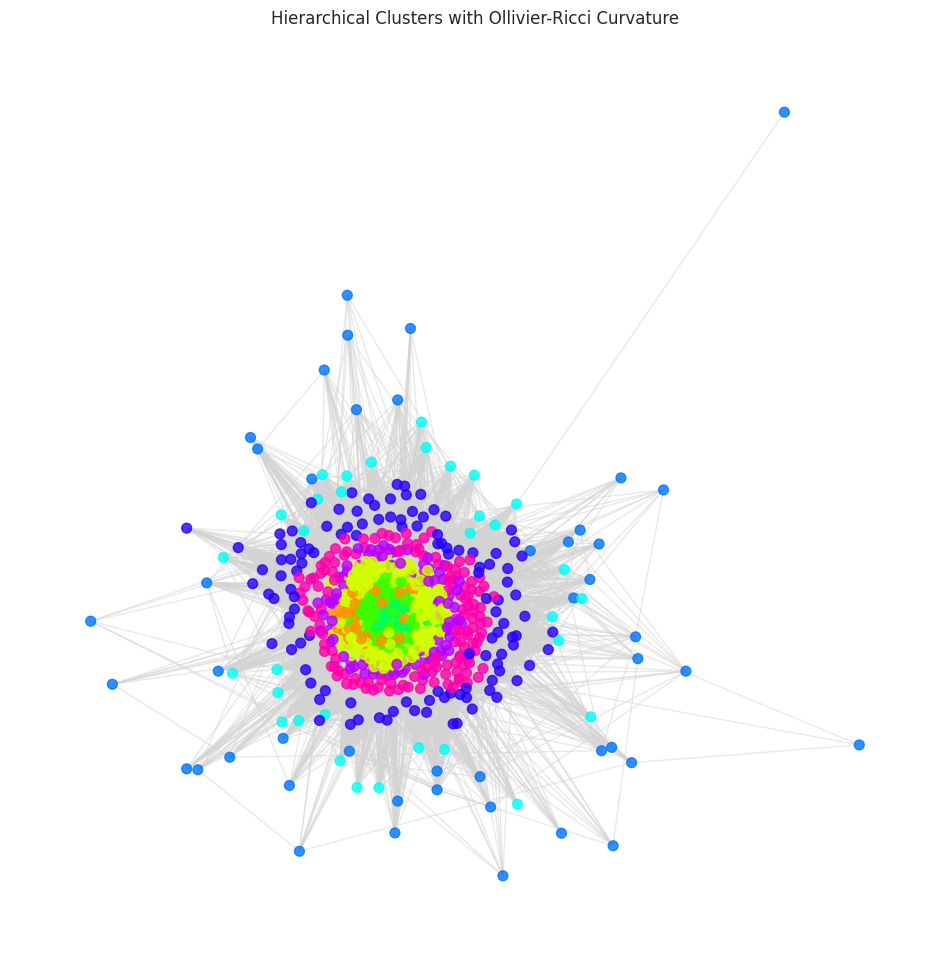

Visualizing hierarchical clusters for Forman-Ricci...


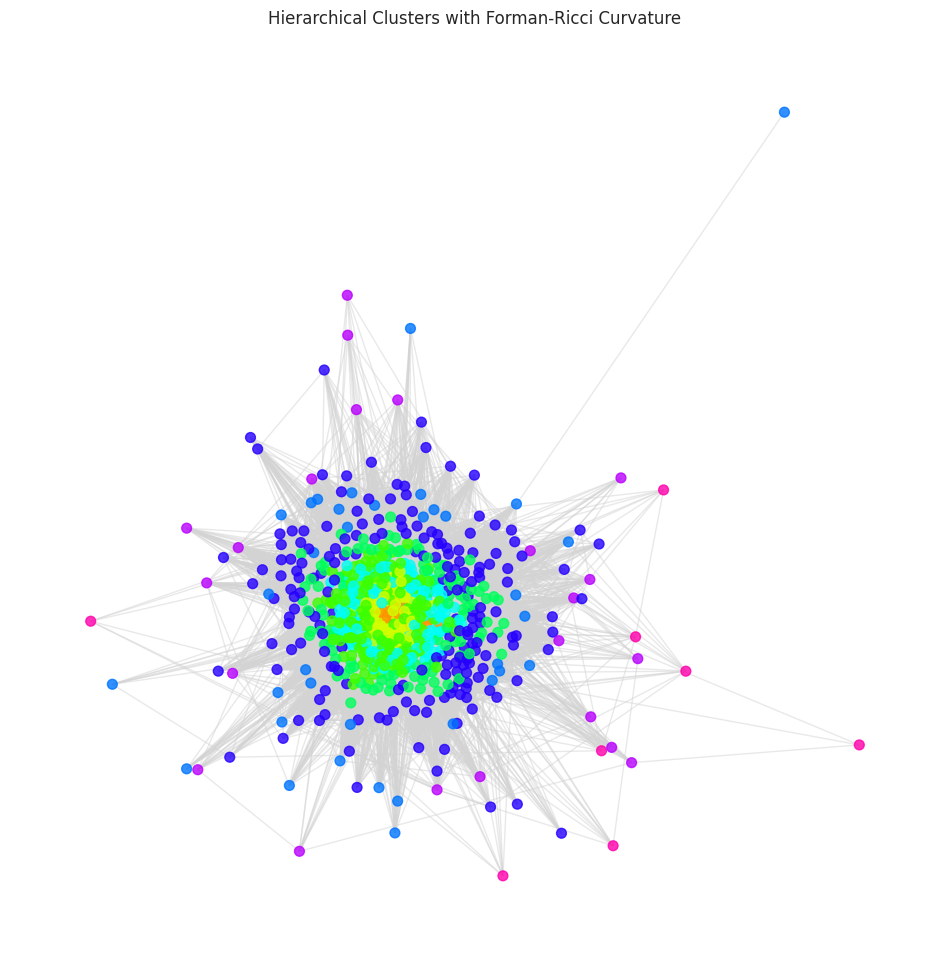

Visualizing hierarchical clusters without Ricci curvature...


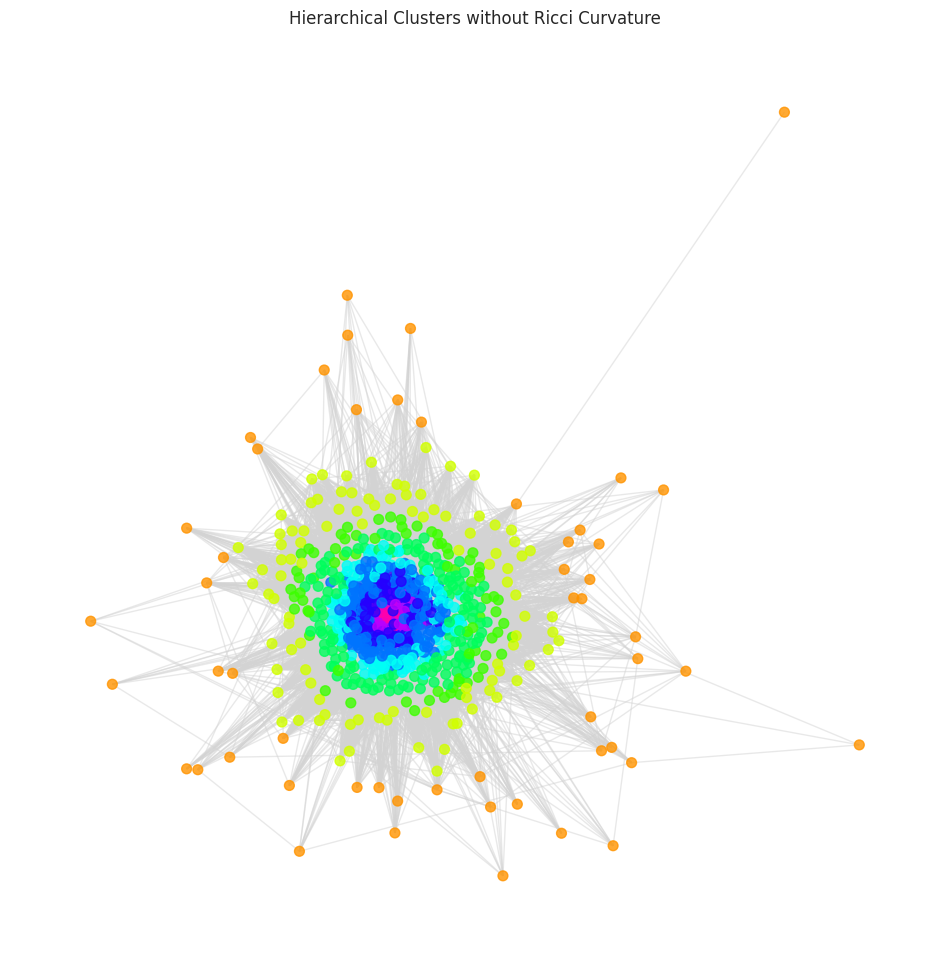


Hierarchical Cluster Sizes with Ollivier-Ricci Curvature
Cluster 6: 45 nodes
Cluster 2: 161 nodes
Cluster 4: 65 nodes
Cluster 9: 142 nodes
Cluster 8: 86 nodes
Cluster 3: 127 nodes
Cluster 1: 48 nodes
Cluster 7: 115 nodes
Cluster 5: 33 nodes

Hierarchical Cluster Sizes with Forman-Ricci Curvature
Cluster 8: 22 nodes
Cluster 3: 177 nodes
Cluster 1: 45 nodes
Cluster 4: 115 nodes
Cluster 2: 99 nodes
Cluster 7: 194 nodes
Cluster 5: 126 nodes
Cluster 6: 36 nodes
Cluster 9: 8 nodes

Hierarchical Cluster Sizes without Ricci Curvature
Cluster 2: 98 nodes
Cluster 6: 163 nodes
Cluster 8: 41 nodes
Cluster 5: 100 nodes
Cluster 9: 34 nodes
Cluster 7: 117 nodes
Cluster 3: 75 nodes
Cluster 1: 52 nodes
Cluster 4: 142 nodes


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

# Step 1: Perform Hierarchical Clustering
def perform_hierarchical_clustering(features, n_clusters=9, method="ward"):
    """
    Perform hierarchical clustering using specified linkage method.
    """
    linkage_matrix = linkage(features, method=method)
    labels = fcluster(linkage_matrix, t=n_clusters, criterion="maxclust")
    return labels, linkage_matrix

print("Hierarchical clustering with Ollivier-Ricci...")
labels_hierarchical_ollivier, linkage_ollivier = perform_hierarchical_clustering(
    features_ollivier_scaled
)

print("Hierarchical clustering with Forman-Ricci...")
labels_hierarchical_forman, linkage_forman = perform_hierarchical_clustering(
    features_forman_scaled
)

print("Hierarchical clustering without Ricci curvature...")
labels_hierarchical_no_ricci, linkage_no_ricci = perform_hierarchical_clustering(
    features_no_ricci_scaled
)

# Step 2: Map cluster results to node names
def map_clusters_to_names(graph, labels, is_integer_labeled=False):
    """
    Map clustering results to node names.
    If `is_integer_labeled` is True, map integer-labeled nodes back to original names.
    """
    cluster_mapping = {}

    for node, label in zip(graph.nodes, labels):
        if is_integer_labeled:
            # Map integer-labeled node back to the original node ID
            original_node = reverse_mapping[node]
            node_name = business_id_to_name.get(original_node, "Unknown")
        else:
            # Use the business ID directly
            node_name = business_id_to_name.get(node, "Unknown")

        if label not in cluster_mapping:
            cluster_mapping[label] = []
        cluster_mapping[label].append(node_name)

    return cluster_mapping

reverse_mapping = {v: k for k, v in node_mapping.items()}

print("Mapping hierarchical clusters to node names for Ollivier-Ricci...")
hierarchical_clusters_ollivier = map_clusters_to_names(
    G_largest_cc, labels_hierarchical_ollivier, is_integer_labeled=False
)

print("Mapping hierarchical clusters to node names for Forman-Ricci...")
hierarchical_clusters_forman = map_clusters_to_names(
    G_largest_cc_int, labels_hierarchical_forman, is_integer_labeled=True
)

print("Mapping hierarchical clusters to node names without Ricci curvature...")
hierarchical_clusters_no_ricci = map_clusters_to_names(
    G_largest_cc, labels_hierarchical_no_ricci, is_integer_labeled=False
)

# Step 3: Visualize Dendrogram for Hierarchical Clustering
def plot_dendrogram(linkage_matrix, title):
    """
    Plot dendrogram for hierarchical clustering.
    """
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, truncate_mode="level", p=10, leaf_rotation=90, leaf_font_size=10)
    plt.title(title)
    plt.xlabel("Node Index")
    plt.ylabel("Distance")
    plt.show()

print("Plotting dendrogram for Ollivier-Ricci...")
plot_dendrogram(linkage_ollivier, "Dendrogram for Ollivier-Ricci Curvature")

print("Plotting dendrogram for Forman-Ricci...")
plot_dendrogram(linkage_forman, "Dendrogram for Forman-Ricci Curvature")

print("Plotting dendrogram without Ricci curvature...")
plot_dendrogram(linkage_no_ricci, "Dendrogram without Ricci Curvature")

# Step 4: Visualize Clusters
def visualize_clusters(graph, labels, title):
    """
    Visualize clusters using node positions and cluster labels.
    """
    pos = nx.spring_layout(graph, seed=42)
    plt.figure(figsize=(12, 12))

    # Dynamically assign colors to clusters
    n_clusters = len(set(labels))
    cluster_colors = sns.color_palette("hsv", n_colors=n_clusters)
    color_map = [cluster_colors[label - 1] for label in labels]

    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, node_color=color_map, node_size=50, alpha=0.8)
    nx.draw_networkx_edges(graph, pos, edge_color="lightgray", alpha=0.5)

    # Add title
    plt.title(title)
    plt.axis("off")
    plt.show()

print("Visualizing hierarchical clusters for Ollivier-Ricci...")
visualize_clusters(
    G_largest_cc, labels_hierarchical_ollivier, "Hierarchical Clusters with Ollivier-Ricci Curvature"
)

print("Visualizing hierarchical clusters for Forman-Ricci...")
visualize_clusters(
    G_largest_cc_int, labels_hierarchical_forman, "Hierarchical Clusters with Forman-Ricci Curvature"
)

print("Visualizing hierarchical clusters without Ricci curvature...")
visualize_clusters(
    G_largest_cc, labels_hierarchical_no_ricci, "Hierarchical Clusters without Ricci Curvature"
)

# Step 5: Print Cluster Sizes
def print_cluster_sizes(cluster_mapping, title):
    print(f"\n{title}")
    for cluster, nodes in cluster_mapping.items():
        print(f"Cluster {cluster}: {len(nodes)} nodes")

print_cluster_sizes(hierarchical_clusters_ollivier, "Hierarchical Cluster Sizes with Ollivier-Ricci Curvature")
print_cluster_sizes(hierarchical_clusters_forman, "Hierarchical Cluster Sizes with Forman-Ricci Curvature")
print_cluster_sizes(hierarchical_clusters_no_ricci, "Hierarchical Cluster Sizes without Ricci Curvature")


normalised count for hierarchical clustering

In [ ]:
# Map clusters to business IDs and texts
def map_hierarchical_clusters_to_ids_and_text(graph, labels, review_data, is_integer_labeled=False):
    """
    Map clustering results to business IDs and their associated review texts.
    """
    cluster_mapping = {}

    for node, label in zip(graph.nodes, labels):
        if is_integer_labeled:
            # Map integer-labeled node back to the original node ID
            original_node = reverse_mapping[node]
            business_id = original_node
        else:
            business_id = node

        # Get review texts and business IDs from review_data
        reviews = review_data[review_data['business_id'] == business_id]

        if label not in cluster_mapping:
            cluster_mapping[label] = []

        # Add (business_id, text) tuples
        cluster_mapping[label].extend(
            reviews[['business_id', 'text']].to_records(index=False)
        )

    return cluster_mapping


# Step 1: Map hierarchical clusters to business IDs and texts
print("Mapping hierarchical clusters with Ollivier-Ricci to business IDs and texts...")
hierarchical_clusters_ollivier_texts = map_hierarchical_clusters_to_ids_and_text(
    G_largest_cc, labels_hierarchical_ollivier, filtered_reviews, is_integer_labeled=False
)

print("Mapping hierarchical clusters with Forman-Ricci to business IDs and texts...")
hierarchical_clusters_forman_texts = map_hierarchical_clusters_to_ids_and_text(
    G_largest_cc_int, labels_hierarchical_forman, filtered_reviews, is_integer_labeled=True
)

print("Mapping hierarchical clusters without Ricci curvature to business IDs and texts...")
hierarchical_clusters_no_ricci_texts = map_hierarchical_clusters_to_ids_and_text(
    G_largest_cc, labels_hierarchical_no_ricci, filtered_reviews, is_integer_labeled=False
)


# Print clusters with business IDs and texts
def print_hierarchical_clusters_with_text(cluster_mapping, title):
    print(f"\n{title}")
    for cluster, nodes in cluster_mapping.items():
        print(f"Cluster {cluster}:")
        for business_id, text in nodes[:5]:  # Show first 5 businesses and texts
            print(f"  Business ID: {business_id}")
            print(f"  Text: {text[:100]}...")  # Show first 100 characters of the review text
        print("...")

print_hierarchical_clusters_with_text(hierarchical_clusters_ollivier_texts, "Hierarchical Clusters with Ollivier-Ricci Curvature")
print_hierarchical_clusters_with_text(hierarchical_clusters_forman_texts, "Hierarchical Clusters with Forman-Ricci Curvature")
print_hierarchical_clusters_with_text(hierarchical_clusters_no_ricci_texts, "Hierarchical Clusters without Ricci Curvature")


# Step 2: Calculate normalized word counts for hierarchical clusters
print("Calculating normalized word counts for hierarchical clusters...")

# Step 2.1: Preprocessing function for reviews
def preprocess_reviews(text):
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()

    tokens = word_tokenize(text.lower())
    tokens = [ps.stem(word) for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

# Step 2.2: Calculate normalized word counts per business
def calculate_normalized_counts(reviews_df):
    business_word_counts = {}
    business_review_counts = reviews_df['business_id'].value_counts()

    for business_id, group in reviews_df.groupby('business_id'):
        combined_text = " ".join(group['text'])
        tokens = preprocess_reviews(combined_text)

        word_freq = FreqDist(tokens)
        total_reviews = business_review_counts[business_id]

        business_word_counts[business_id] = {word: count / total_reviews for word, count in word_freq.items()}

    return business_word_counts

# Step 2.3: Aggregate normalized counts at the cluster level
def calculate_cluster_word_counts(cluster_mapping, business_word_counts):
    cluster_word_counts = defaultdict(lambda: defaultdict(float))

    for cluster_id, business_ids in cluster_mapping.items():
        for business_id_record in business_ids:
            business_id = business_id_record[0]
            word_counts = business_word_counts.get(business_id, {})
            for word, norm_count in word_counts.items():
                cluster_word_counts[cluster_id][word] += norm_count

    return cluster_word_counts

# Step 2.4: Extract top 10 words for each cluster
def get_top_words(cluster_word_counts, top_n=10):
    cluster_top_words = {}
    for cluster_id, word_counts in cluster_word_counts.items():
        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        cluster_top_words[cluster_id] = sorted_words[:top_n]
    return cluster_top_words

# Perform calculations
print("Calculating normalized word counts...")
business_word_counts = calculate_normalized_counts(filtered_reviews)

print("Aggregating normalized counts for hierarchical clusters...")
hierarchical_cluster_word_counts_ollivier = calculate_cluster_word_counts(hierarchical_clusters_ollivier_texts, business_word_counts)

# Step 3: Extract and display top words
print("Extracting top words for hierarchical clusters...")
top_words_hierarchical_ollivier = get_top_words(hierarchical_cluster_word_counts_ollivier)

def display_cluster_top_words(top_words, title):
    print(f"\nTop Words for {title}:")
    for cluster_id, words in top_words.items():
        print(f"Cluster {cluster_id}:")
        for word, count in words:
            print(f"  {word}: {count:.4f}")
        print()

display_cluster_top_words(top_words_hierarchical_ollivier, "Hierarchical Clusters with Ollivier-Ricci Curvature")


Mapping hierarchical clusters with Ollivier-Ricci to business IDs and texts...
Mapping hierarchical clusters with Forman-Ricci to business IDs and texts...
Mapping hierarchical clusters without Ricci curvature to business IDs and texts...

Hierarchical Clusters with Ollivier-Ricci Curvature
Cluster 6:
  Business ID: lsHmnOZNlsKnEDsNmT-5_Q
  Text: American Home Water just installed a 50 gallon Bradford White water heater for me. They were fantast...
  Business ID: lsHmnOZNlsKnEDsNmT-5_Q
  Text: 5 star service from Brad and American. Zero pressure from this company and they actually provided qu...
  Business ID: lsHmnOZNlsKnEDsNmT-5_Q
  Text: Fidel and Tyler changed out my RO filters and hooked up my ice machine line today. Both very profess...
  Business ID: lsHmnOZNlsKnEDsNmT-5_Q
  Text: I appreciate the service provided by American Home Water and Air. I have found this company to be re...
  Business ID: lsHmnOZNlsKnEDsNmT-5_Q
  Text: I used this company for a water softener installati

LDA for hierarchical Clustering

In [ ]:
# Map clusters to texts for Hierarchical Clustering
print("Preparing cluster texts for Hierarchical Clustering...")
cluster_texts_hierarchical = prepare_cluster_texts(filtered_reviews, hierarchical_clusters_ollivier_texts)

print("Applying LDA to all Hierarchical Clusters...")
lda_topics_hierarchical = apply_lda_for_clusters(cluster_texts_hierarchical)

# Display topics for all clusters
display_topics_for_clusters(lda_topics_hierarchical, "LDA Topics for Hierarchical Clusters")


Preparing cluster texts for Hierarchical Clustering...
Applying LDA to all Hierarchical Clusters...

LDA Topics for Hierarchical Clusters

Cluster 6:
  Topic 1: time, great, service, job, carpet, recommend, company, moving, professional, would
  Topic 2: service, company, day, called, would, time, home, work, call, water
  Topic 3: car, service, great, time, experience, get, would, minute, got, one

Cluster 2:
  Topic 1: food, place, great, good, service, love, best, taco, time, back
  Topic 2: good, food, ordered, chicken, great, place, restaurant, delicious, like, sauce
  Topic 3: place, great, time, like, get, one, good, beer, go, food

Cluster 4:
  Topic 1: great, pizza, good, place, food, delicious, salad, service, time, back
  Topic 2: place, burger, great, good, like, food, get, one, love, time
  Topic 3: food, place, great, good, taco, time, service, get, chicken, one

Cluster 9:
  Topic 1: taco, time, food, thai, place, good, salsa, get, like, mexican
  Topic 2: good, food, pl

Evaluation all the Clsuetring Methods using AVI, AVI, ANUI, Modularity, Entropy

In [ ]:
# Evaluation Functions
import numpy as np
import networkx as nx
from scipy.stats import entropy as scipy_entropy

def calculate_avi(G, clusters):
    """Average Isolability (AVI)"""
    node_list = list(G.nodes())  # Ensure correct ordering of nodes

    # Handle mismatch between clusters and node list
    if len(clusters) != len(node_list):
        print("Warning: Mismatch between clusters and nodes. Assigning default cluster ID to missing nodes.")
        clusters = list(clusters) + [-1] * (len(node_list) - len(clusters))

    # Map clusters to node names
    cluster_assignments = {node_list[i]: clusters[i] for i in range(len(node_list))}

    # Create a dictionary for edges within clusters
    cluster_edges = {i: [] for i in set(clusters) if i != -1}  # Exclude default cluster
    for u, v in G.edges():
        # Skip edges where either node belongs to the default cluster
        if cluster_assignments[u] == -1 or cluster_assignments[v] == -1:
            continue
        if cluster_assignments[u] == cluster_assignments[v]:
            cluster_edges[cluster_assignments[u]].append((u, v))

    # Compute AVI
    avi_values = []
    for c in cluster_edges:
        intra_edges = len(cluster_edges[c])
        inter_edges = sum(
            1
            for u, v in G.edges()
            if cluster_assignments[u] == c and cluster_assignments[v] != c and cluster_assignments[v] != -1
        )
        avi = intra_edges / (intra_edges + inter_edges + 1e-9)  # Avoid division by zero
        avi_values.append(avi)
    return np.mean(avi_values) if avi_values else 0


def calculate_avu(G, clusters):
    """Average Unifiability (AVU)"""
    node_list = list(G.nodes())  # Ensure correct ordering of nodes

    # Handle mismatch between clusters and node list
    if len(clusters) != len(node_list):
        print("Warning: Mismatch between clusters and nodes. Assigning default cluster ID to missing nodes.")
        clusters = list(clusters) + [-1] * (len(node_list) - len(clusters))

    # Map clusters to node names
    cluster_assignments = {node_list[i]: clusters[i] for i in range(len(node_list))}

    avu_values = []
    for cluster_id in set(clusters):
        if cluster_id == -1:
            continue  # Skip default cluster
        cluster_nodes = [node for node in G.nodes() if cluster_assignments[node] == cluster_id]
        intra_edges = sum(1 for u, v in G.edges(cluster_nodes) if cluster_assignments[u] == cluster_assignments[v])
        degrees = sum(G.degree(node) for node in cluster_nodes)
        avu = intra_edges / (intra_edges + degrees + 1e-9)
    return np.mean(avu_values) if avu_values else 0


def calculate_anui(avi, avu):
    """Average Normalized Unifiability and Isolability (ANUI)"""
    return (2 * avi * avu) / (avi + avu + 1e-9)


def calculate_modularity(G, clusters):
    """Modularity"""
    # Create communities from clusters
    communities = {i: [] for i in set(clusters)}
    for node, cluster_id in zip(G.nodes(), clusters):
        if cluster_id != -1:  # Exclude default cluster
            communities[cluster_id].append(node)
    community_list = [community for community in communities.values() if community]
    return nx.community.modularity(G, community_list)


def calculate_entropy(clusters):
    """Entropy of the cluster distribution"""
    cluster_counts = np.bincount([c for c in clusters if c != -1])  # Exclude default cluster
    cluster_probs = cluster_counts / cluster_counts.sum()
    return scipy_entropy(cluster_probs, base=2)  # Use scipy_entropy


# Evaluation Function
def evaluate_clusters(G, clusters, title):
    avi = calculate_avi(G, clusters)
    avu = calculate_avu(G, clusters)
    anui = calculate_anui(avi, avu)
    modularity = calculate_modularity(G, clusters)
    entropy = calculate_entropy(clusters)

    print(f"\n{title} Evaluation:")
    print(f"AVI: {avi:.4f}")
    print(f"AVU: {avu:.4f}")
    print(f"ANUI: {anui:.4f}")
    print(f"Modularity: {modularity:.4f}")
    print(f"Entropy: {entropy:.4f}")


# Example Evaluations
print("Evaluating K-Means Clustering:")
evaluate_clusters(G_largest_cc, labels_ollivier, "K-Means with Ollivier-Ricci")
evaluate_clusters(G_largest_cc_int, labels_forman, "K-Means with Forman-Ricci")
evaluate_clusters(G_largest_cc, labels_no_ricci, "K-Means without Ricci")

print("Evaluating Hierarchical Clustering:")
evaluate_clusters(G_largest_cc, labels_hierarchical_ollivier, "Hierarchical with Ollivier-Ricci")
evaluate_clusters(G_largest_cc_int, labels_hierarchical_forman, "Hierarchical with Forman-Ricci")
evaluate_clusters(G_largest_cc, labels_hierarchical_no_ricci, "Hierarchical without Ricci")

print("Evaluating Spectral Clustering:")
evaluate_clusters(G_largest_cc, labels_spectral_ollivier, "Spectral with Ollivier-Ricci")
evaluate_clusters(G_largest_cc_int, labels_spectral_forman, "Spectral with Forman-Ricci")
evaluate_clusters(G_largest_cc, labels_spectral_no_ricci, "Spectral without Ricci")


Evaluating K-Means Clustering:

K-Means with Ollivier-Ricci Evaluation:
AVI: 0.1538
AVU: 0.0552
ANUI: 0.0813
Modularity: 0.0052
Entropy: 3.0551

K-Means with Forman-Ricci Evaluation:
AVI: 0.1439
AVU: 0.0558
ANUI: 0.0805
Modularity: 0.0149
Entropy: 2.7666

K-Means without Ricci Evaluation:
AVI: 0.1414
AVU: 0.0521
ANUI: 0.0761
Modularity: -0.0009
Entropy: 3.0931
Evaluating Hierarchical Clustering:

Hierarchical with Ollivier-Ricci Evaluation:
AVI: 0.1513
AVU: 0.0555
ANUI: 0.0812
Modularity: 0.0059
Entropy: 2.9967

Hierarchical with Forman-Ricci Evaluation:
AVI: 0.1450
AVU: 0.0560
ANUI: 0.0808
Modularity: 0.0164
Entropy: 2.7801

Hierarchical without Ricci Evaluation:
AVI: 0.1439
AVU: 0.0521
ANUI: 0.0764
Modularity: -0.0001
Entropy: 3.0093
Evaluating Spectral Clustering:

Spectral with Ollivier-Ricci Evaluation:
AVI: 0.1595
AVU: 0.0557
ANUI: 0.0826
Modularity: 0.0052
Entropy: 3.0092

Spectral with Forman-Ricci Evaluation:
AVI: 0.1481
AVU: 0.0557
ANUI: 0.0810
Modularity: 0.0085
Entropy: 2.9

In [ ]:
def evaluate_clusters_with_dominant_category(clusters, business_data, refined_category_col="refined_category"):
    """
    Evaluate clusters by identifying the dominant category,
    its percentage, and the number of nodes for that category.

    Parameters:
    - clusters: Dictionary mapping cluster IDs to lists of nodes
    - business_data: DataFrame containing business data with `refined_category_col`
    - refined_category_col: Column name for categories in business data

    Returns:
    - Dictionary with cluster evaluation results
    """
    cluster_evaluation = {}

    for cluster_id, cluster_nodes in clusters.items():
        category_counts = defaultdict(int)

        # Count categories in the cluster
        for node in cluster_nodes:
            category = business_data.loc[business_data['business_id'] == node, refined_category_col ].values
            category = category[0] if len(category) > 0 else "Unknown"  # Get the category if exists
            category_counts[category] += 1

        # Find the dominant category and calculate its metrics
        if category_counts:
            dominant_category = max(category_counts, key=category_counts.get)
            dominant_count = category_counts[dominant_category]
            total_nodes = len(cluster_nodes)
            dominant_percentage = (dominant_count / total_nodes) * 100 if total_nodes > 0 else 0
            cluster_evaluation[cluster_id] = {
                "dominant_category": dominant_category,
                "dominant_percentage": dominant_percentage,
                "dominant_count": dominant_count,
                "total_nodes": total_nodes,
            }
        else:
            cluster_evaluation[cluster_id] = {
                "dominant_category": "Unknown",
                "dominant_percentage": 0,
                "dominant_count": 0,
                "total_nodes": 0,
            }

    return cluster_evaluation


# Evaluate clusters for each scenario
print("Evaluating K-Means Clusters with Ollivier-Ricci...")
category_eval_ollivier = evaluate_clusters_with_dominant_category(
    clusters_ollivier_mapped, phoenix_businesses, refined_category_col="refined_category"
)
print("\nResults for Ollivier-Ricci:")
for cluster_id, result in category_eval_ollivier.items():
    print(f"Cluster {cluster_id}:")
    print(f"  Dominant Category: {result['dominant_category']}")
    print(f"  Percentage: {result['dominant_percentage']:.2f}%")
    print(f"  Count: {result['dominant_count']} / {result['total_nodes']}")

print("\nEvaluating K-Means Clusters with Forman-Ricci...")
category_eval_forman = evaluate_clusters_with_dominant_category(
    clusters_forman_mapped, phoenix_businesses, refined_category_col="refined_category"
)
print("\nResults for Forman-Ricci:")
for cluster_id, result in category_eval_forman.items():
    print(f"Cluster {cluster_id}:")
    print(f"  Dominant Category: {result['dominant_category']}")
    print(f"  Percentage: {result['dominant_percentage']:.2f}%")
    print(f"  Count: {result['dominant_count']} / {result['total_nodes']}")

print("\nEvaluating K-Means Clusters without Ricci curvature...")
category_eval_no_ricci = evaluate_clusters_with_dominant_category(
    clusters_no_ricci_mapped, phoenix_businesses, refined_category_col="refined_category"
)
print("\nResults without Ricci curvature:")
for cluster_id, result in category_eval_no_ricci.items():
    print(f"Cluster {cluster_id}:")
    print(f"  Dominant Category: {result['dominant_category']}")
    print(f"  Percentage: {result['dominant_percentage']:.2f}%")
    print(f"  Count: {result['dominant_count']} / {result['total_nodes']}")


Evaluating K-Means Clusters with Ollivier-Ricci...

Results for Ollivier-Ricci:
Cluster 3:
  Dominant Category: Home Services
  Percentage: 73.68%
  Count: 28 / 38
Cluster 8:
  Dominant Category: Restaurants
  Percentage: 82.95%
  Count: 107 / 129
Cluster 0:
  Dominant Category: Restaurants
  Percentage: 83.33%
  Count: 105 / 126
Cluster 2:
  Dominant Category: Restaurants
  Percentage: 81.60%
  Count: 102 / 125
Cluster 4:
  Dominant Category: Restaurants
  Percentage: 86.00%
  Count: 43 / 50
Cluster 5:
  Dominant Category: Restaurants
  Percentage: 80.31%
  Count: 102 / 127
Cluster 6:
  Dominant Category: Restaurants
  Percentage: 61.97%
  Count: 44 / 71
Cluster 1:
  Dominant Category: Restaurants
  Percentage: 72.45%
  Count: 71 / 98
Cluster 7:
  Dominant Category: Home Services
  Percentage: 37.93%
  Count: 22 / 58

Evaluating K-Means Clusters with Forman-Ricci...

Results for Forman-Ricci:
Cluster 1:
  Dominant Category: Unknown
  Percentage: 100.00%
  Count: 29 / 29
Cluster 7:
  D